In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.optimize import minimize 

import sys

import warnings
warnings.filterwarnings("ignore")

from myLibraries.queries import * 
from myLibraries.events import *

In [3]:
# GLOBAL NOTEBOOK SETTINGS
HOLE_SIZE = 28
YEARS = get_str_years_event()
events = get_collabs_event() 
all_events = [e for e in range(events[-1])]

# **(1) Plot average trajectories**

<center><img src="./assets/0.png" style="width: 1000px;"></center>

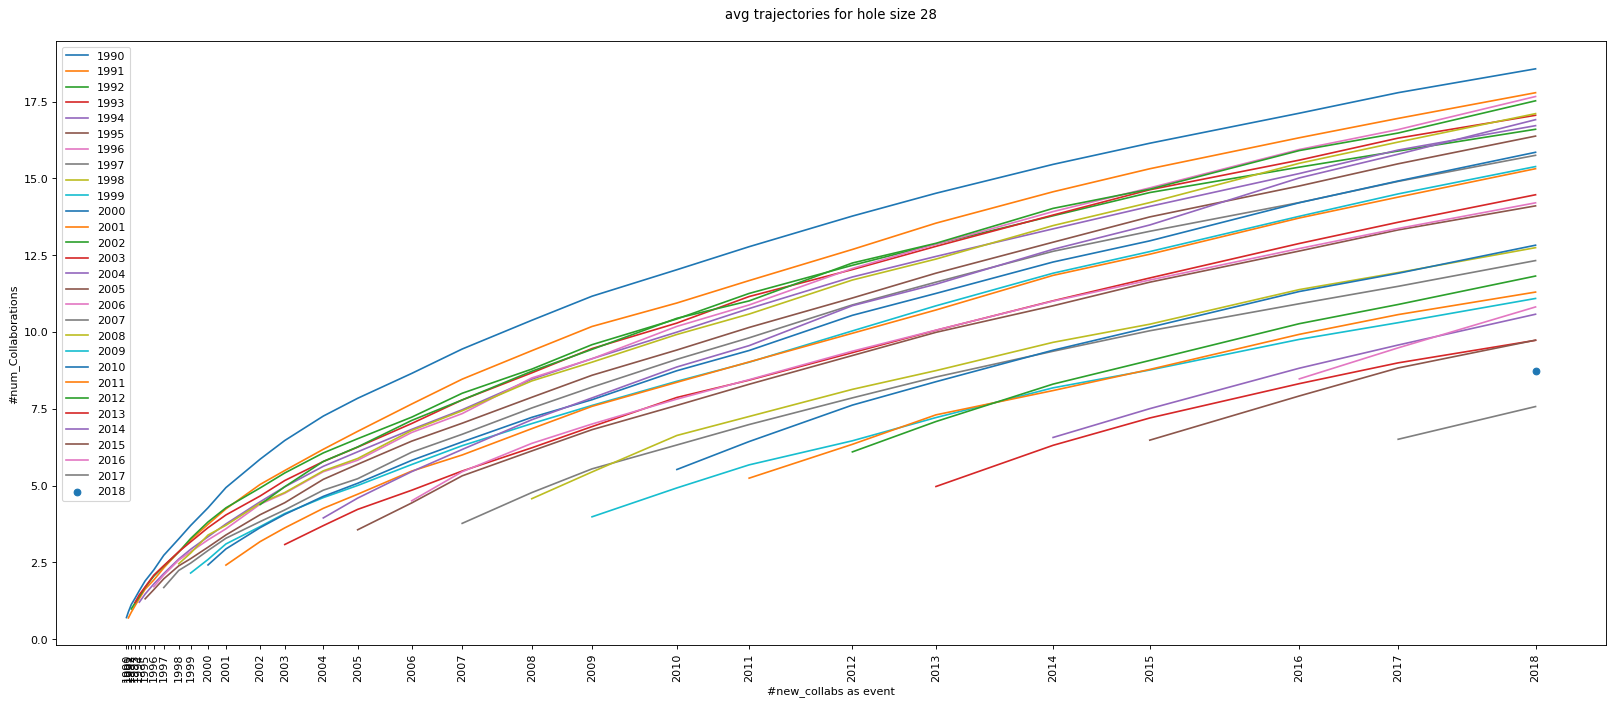

In [5]:
## Plot average trajectories 

plt.figure(figsize=(25, 10), dpi=80)

plt.title("avg trajectories for hole size " + str(HOLE_SIZE) + "\n", fontdict = {'fontsize' : 12})
plt.xlabel("#new_collabs as event")
plt.ylabel("#num_Collaborations")

plt.xticks(rotation='vertical')

for start_y in YEARS:

    x,y = get_avg_trajectories(events, HOLE_SIZE, start_y)
    
    if(len(y)==1):
        plt.scatter(x,y)
    else:
        plt.plot(x,y)
    
    plt.xticks(x, y)
    plt.xticks(rotation='vertical')
    
plt.legend(YEARS, loc='upper left')
plt.xticks(events, YEARS)
plt.show()

# **(2) Plotting fitting function**

<center><img src="./assets/1.jpg" style="width: 1000px;"></center>

In [6]:
# Theoretichal vertex trajectory for stretched exponential distribution
def func(x, a, b, curr_x):
    return a* pow((np.log(x/curr_x) + 1), b)

# Method to fit the theoretical trajectory to the given average trajectory 
def fit_trajectory(xdata, ydata, curr_x):
    
    popt, pcov = curve_fit(lambda x, a, b: func(x, a, b, curr_x), xdata, ydata, maxfev=5000)
    alpha = popt[0]
    beta = popt[1]

    return func(xdata, alpha, beta, curr_x), alpha, beta 

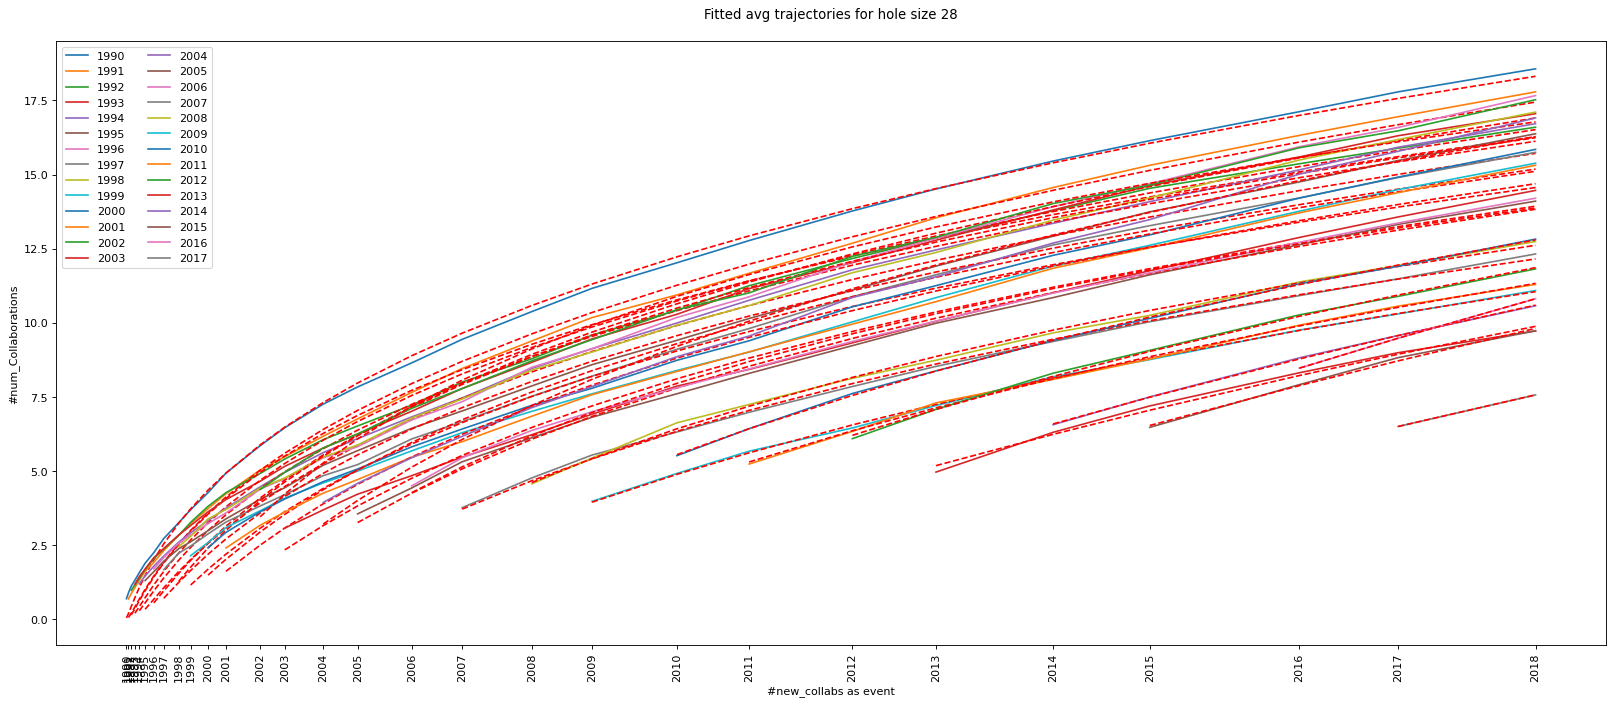

In [7]:
## Plot fitted average trjectories

plt.figure(figsize=(25, 10), dpi=80)
plt.title("Fitted avg trajectories for hole size " + str(HOLE_SIZE) + "\n", fontdict = {'fontsize' : 12})
plt.xlabel("#new_collabs as event")
plt.ylabel("#num_Collaborations")
plt.xticks(rotation='vertical')

alphas = []
betas = []
for start_y in YEARS[:-1]:

    curr_x = events[YEARS.index(start_y)]  
    x,y = get_avg_trajectories(events, HOLE_SIZE, start_y) # retrieve average trajecory for the given start_y (and hole size) 
    
    fit_y, alpha, beta = fit_trajectory(x, y, curr_x) # fit the real data above with the theoretical trajectory 

    # save fitted parameters alpha, beta
    alphas.append(alpha)
    betas.append(beta)
    
    plt.plot(x,y, label=str(start_y))
    plt.plot(x,fit_y, 'r--')
    
    plt.xticks(x, fit_y)
    plt.xticks(rotation='vertical')
    
plt.legend(loc='upper left', ncol=2)
plt.xticks(events, YEARS)
plt.show()

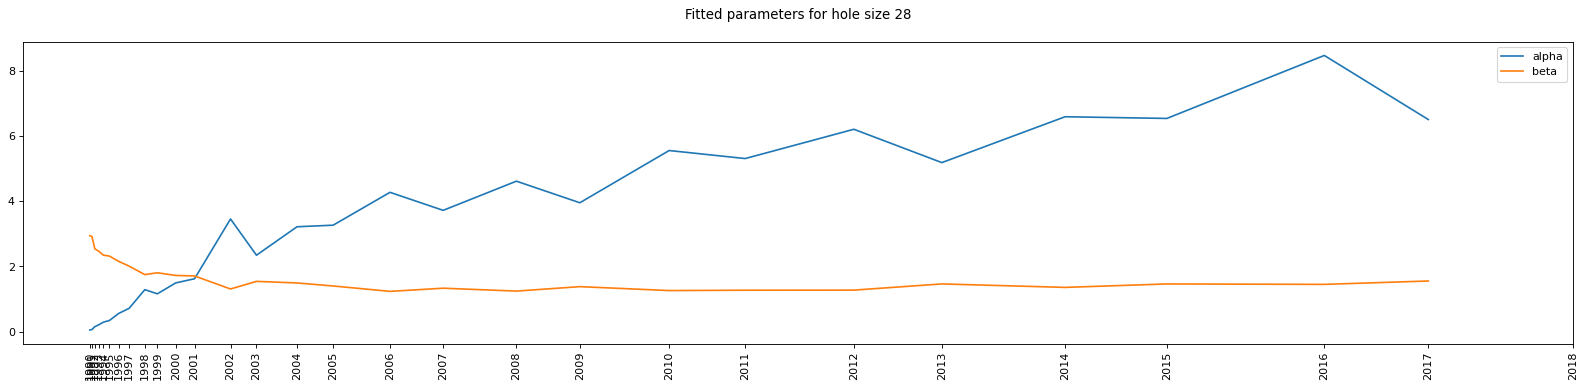

   start_y     alpha      beta
0     1990  0.052229  2.945541
1     1991  0.066069  2.921379
2     1992  0.154545  2.539907
3     1993  0.210791  2.468087
4     1994  0.292164  2.348714
5     1995  0.344879  2.317650
6     1996  0.558043  2.159069
7     1997  0.716271  2.010816
8     1998  1.289671  1.751494
9     1999  1.161873  1.807135
10    2000  1.495691  1.725676
11    2001  1.623524  1.709678
12    2002  3.457902  1.310306
13    2003  2.345930  1.543521
14    2004  3.218471  1.495270
15    2005  3.267107  1.402426
16    2006  4.274786  1.236836
17    2007  3.721863  1.333927
18    2008  4.616882  1.245440
19    2009  3.955028  1.381840
20    2010  5.557048  1.261548
21    2011  5.310683  1.272497
22    2012  6.208824  1.275338
23    2013  5.186650  1.465240
24    2014  6.593064  1.358855
25    2015  6.541392  1.464503
26    2016  8.473198  1.451313
27    2017  6.507219  1.555216


In [8]:
## Plotting and Printing fitted parameters alpha and beta for each starting year
plt.figure(figsize=(25, 5), dpi=80)
plt.title("Fitted parameters for hole size " + str(HOLE_SIZE) + "\n", fontdict = {'fontsize' : 12})
plt.plot(events[:-1], alphas, label="alpha")
plt.plot(events[:-1], betas, label="beta")
plt.xticks(events, YEARS)
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

print(pd.DataFrame([[YEARS[i], alphas[i], betas[i]] for i in range(len(alphas))], columns=["start_y", "alpha", "beta"]))

# **(3)** Find **alpha\* and beta\*** to have a function **f\*** minimizing the **errors** 

given a starting event $i$:
- Let $e$ be a generic event
- Let $r_i(e)$ be the function representing the real average trajectory for authors who started to publish at the event $i$
- Let $f_i(e)$ be the fitted function of $r_i(e)$
- Let $f_i^*(e)$ be the general fitting function of which we want to optimized the parameters, for authors who started to publish at the event $i$

## A) $min_{\alpha^*,\sigma^*} \Biggl( \sum_i \sum_{e\geq i} |f_i^* (e) - r_i(e) |^2 \Biggr)$
## B) $min_{\alpha^*,\sigma^*} \Biggl( \sum_i \max_{e\geq i} |f_i^* (e) - r_i(e) |^2 \Biggr)$ 

## C) $min_{\alpha^*,\sigma^*} \Biggl( \sum_i \sum_{e\geq i} |f_i^* (e) - f_i(e) |^2 \Biggr)$ 
## D) $min_{\alpha^*,\sigma^*} \Biggl( \sum_i \max_{e\geq i} |f_i^* (e) - f_i(e) |^2 \Biggr)$ 

In [302]:
## error function to minimize in order to find alpha* and beta*
    ## this function compare f* with real data 
def err_f_A(params, xdata, hole_size):
    opt_alpha, opt_beta = params
    err = 0
    for start_y in YEARS[:-1]:
        i = YEARS.index(start_y)
        x,y = get_avg_trajectories(xdata, hole_size, start_y)
        for curr_y in YEARS[i:][:-1]:
            e = YEARS.index(curr_y)
            err += pow(abs(func(xdata[e], opt_alpha, opt_beta, xdata[i]) - y[YEARS[i:][:-1].index(curr_y)]), 2)

    sys.stdout.write('\r'+ "optimizing A function with -> params: " + str(params) +", error: "+ str(err))
    return err


## error function to minimize in order to find alpha* and beta*
    ## this function compare f* with real data 
def err_f_B(params, xdata, hole_size):
    opt_alpha, opt_beta = params
    
    err = 0
    for start_y in YEARS[:-1]:
        i = YEARS.index(start_y)
        
        x,y = get_avg_trajectories(xdata, hole_size, start_y)
        
        tmp = []
        for curr_y in YEARS[i:][:-1]:
            e = YEARS.index(curr_y)
        
            tmp.append(pow(abs(func(xdata[e], opt_alpha, opt_beta, xdata[i]) - y[YEARS[i:][:-1].index(curr_y)]), 2))
        err += np.max(tmp)
    
    sys.stdout.write('\r'+ "optimizing B function with -> params: " + str(params) +", error: "+ str(err))
    return err

SUBSET_SIZE = 200

## error function to minimize in order to find alpha* and beta*
    ## this function compare f* with fitted data f_i 
        ## we consider a subset of events for computational costs
def err_f_C(params, xdata, hole_size):
    opt_alpha, opt_beta = params
    
    size = SUBSET_SIZE # subset of events to consider 
    
    next_events = all_events
    n = (len(next_events))//size
        
    events_subset = [next_events[e] for e in range(len(next_events)) if e%n==0][:size]
        
    err = 0
    for start_y in YEARS[:-1]:
        i = YEARS.index(start_y)    
        curr_x = events[i]  
        
        x,y = get_avg_trajectories(xdata, hole_size, start_y)
        fit_y, alpha, beta = fit_trajectory(x, y, curr_x) # fit the real data above with the theoretical trajectory 
        

        for e in events_subset:
            if(e>curr_x):
                err += pow(abs(func(e, opt_alpha, opt_beta, xdata[i]) - func(e, alpha, beta, xdata[i])), 2)

    sys.stdout.write('\r'+ "optimizing C function with " + str(size) + " events -> params: " + str(params) +", error: "+ str(err))
    return err

## error function to minimize in order to find alpha* and beta*
    ## this function compare f* with fitted data f_i 
        ## we consider a subset of events for computational costs
def err_f_D(params, xdata, hole_size):
    
    opt_alpha, opt_beta = params
    
    size = SUBSET_SIZE # subset of events to consider 
    
    next_events = all_events
    n = (len(next_events))//size
        
    events_subset = [next_events[e] for e in range(len(next_events)) if e%n==0][:size]
    
    err = 0
    for start_y in YEARS[:-1]:
        i = YEARS.index(start_y)
        
        curr_x = events[i]  

        x,y = get_avg_trajectories(xdata, hole_size, start_y)
        fit_y, alpha, beta = fit_trajectory(x, y, curr_x) # fit the real data above with the theoretical trajectory 

        tmp = []
        for e in events_subset:
            if(e>curr_x):
                tmp.append(pow(abs(func(e, opt_alpha, opt_beta, xdata[i]) - func(e, alpha, beta, xdata[i])), 2))
             
        if((len(tmp))!=0):
            err += np.max(tmp)
        
    sys.stdout.write('\r'+ "optimizing D function with " + str(size) + " events -> params: " + str(params) +", error: "+ str(err))
    return err


In [303]:
## optimize alpha* and beta* for each error function defined above 
alphas_opt,betas_opt, errs = [],[],[]

# retrieve alpha* and beta* minimizing the associated function and
    # compute the error made by the optimized parameters 

result_A = minimize(err_f_A, [1, 1], args=(events, HOLE_SIZE))
fitted_params_A = result_A.x
alphas_opt.append(fitted_params_A[0])
betas_opt.append(fitted_params_A[1])
errs.append(err_f_A(fitted_params_A, events, HOLE_SIZE))
print()

result_B = minimize(err_f_B, [1, 1], args=(events, HOLE_SIZE))
fitted_params_B = result_B.x
alphas_opt.append(fitted_params_B[0])
betas_opt.append(fitted_params_B[1])
errs.append(err_f_B(fitted_params_B, events, HOLE_SIZE))
print()

result_C = minimize(err_f_C, [1, 1], args=(events, HOLE_SIZE))
fitted_params_C = result_C.x
alphas_opt.append(fitted_params_C[0])
betas_opt.append(fitted_params_C[1])
errs.append(err_f_C(fitted_params_C, events, HOLE_SIZE))
print()

result_D = minimize(err_f_D, [1, 1], args=(events, HOLE_SIZE))
fitted_params_D = result_D.x
alphas_opt.append(fitted_params_D[0])
betas_opt.append(fitted_params_D[1])
errs.append(err_f_D(fitted_params_D, events, HOLE_SIZE))
print()

print()
print(pd.DataFrame([[errs[i], alphas_opt[i], betas_opt[i]] for i in range(len(errs))], ["err_f_A", "err_f_B", "err_f_C", "err_f_D"], ["ERROR", "alpha", "beta",]))

optimizing A function with -> params: [4.31419319 0.59024867], error: 4529.074754549777
optimizing B function with -> params: [6.08094902 0.45010225], error: 620.851259065931
optimizing C function with 200 events -> params: [6.5377453  0.41969247], error: 32466.473973783515
optimizing D function with 200 events -> params: [5.44999072 0.5440755 ], error: 747.4306652124122

                ERROR     alpha      beta
err_f_A   4529.074755  4.314193  0.590249
err_f_B    620.851259  6.080949  0.450102
err_f_C  32466.473974  6.537745  0.419692
err_f_D    747.430665  5.449991  0.544075


In [315]:
## get general fitting functions by starting year for each couple of parameter found above 
error_f_labels = ["A", "B", "C", "D"] 
error_fit_functions = {}

for i in range(len(error_f_labels)):
    # get general error fitted functions by starting year
    functions_by_start_y = [] # contains fitted error functions for each year 
    for start_y in YEARS[:-1]:
        curr_x = events[YEARS.index(start_y)]  
        x,y = get_avg_trajectories(events, HOLE_SIZE, start_y) # retrieve average trajecory for the given start_y (and hole size) 
        
        general_fit_y = func(x, alphas_opt[i], betas_opt[i], curr_x)
        functions_by_start_y.append(general_fit_y)
    
    error_fit_functions[error_f_labels[i]] = functions_by_start_y

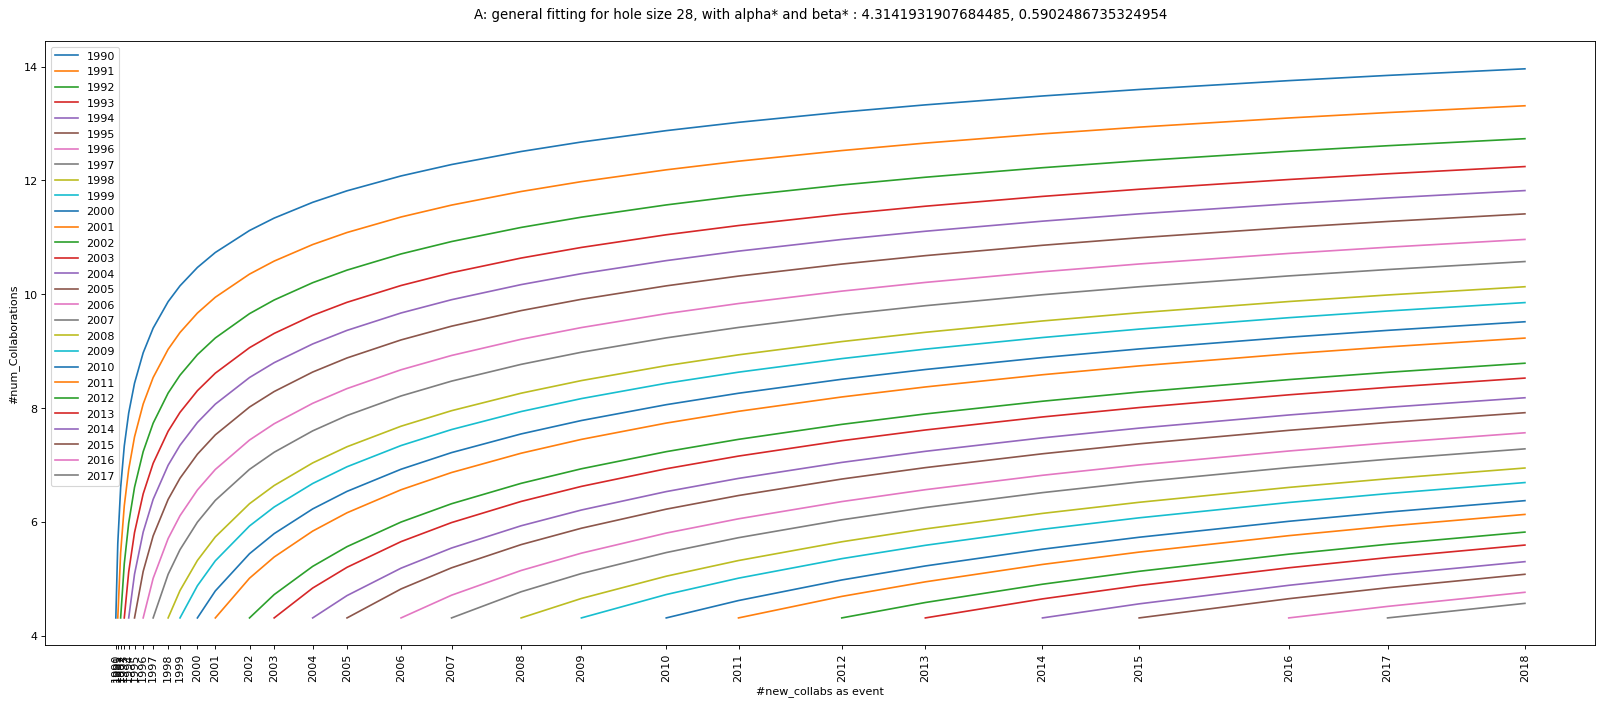

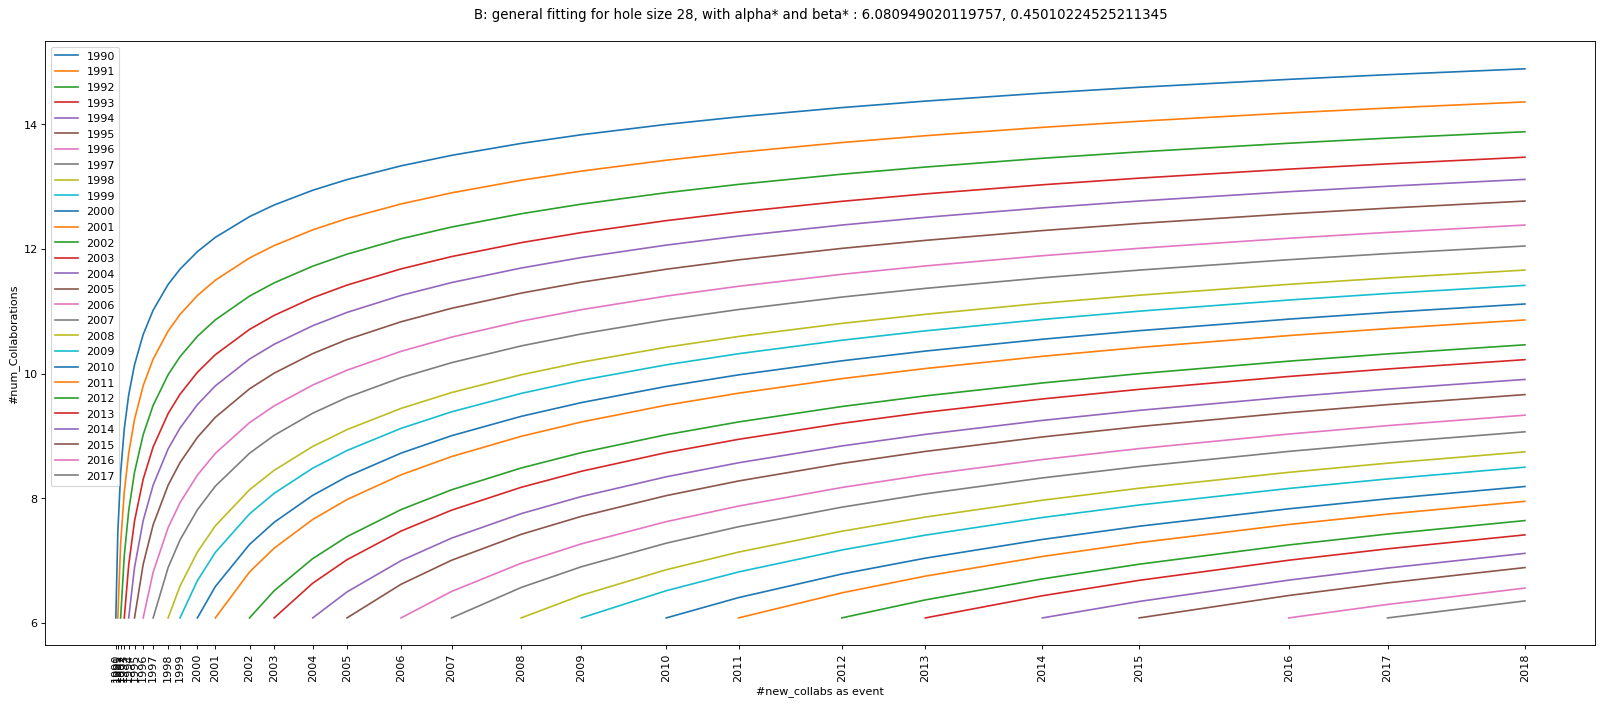

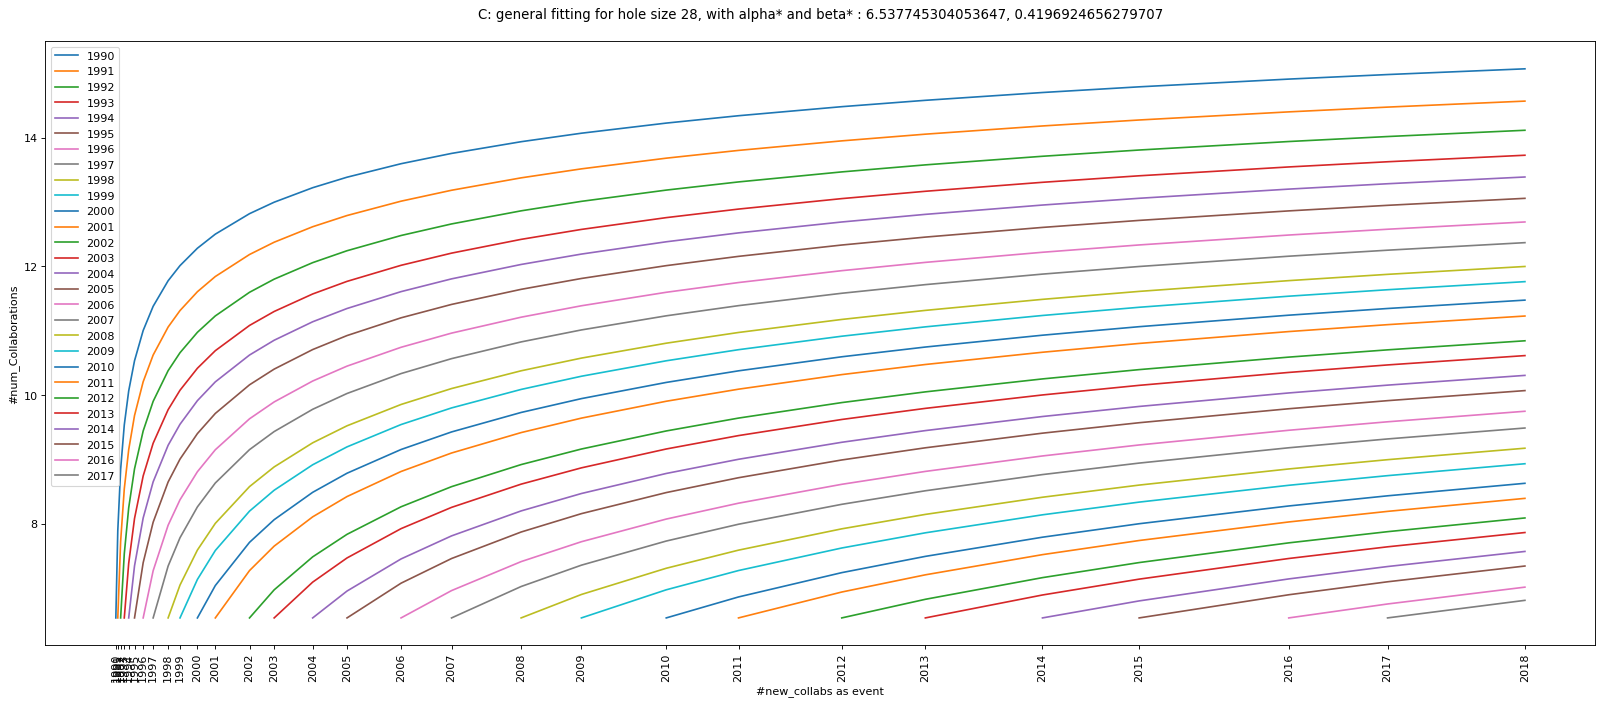

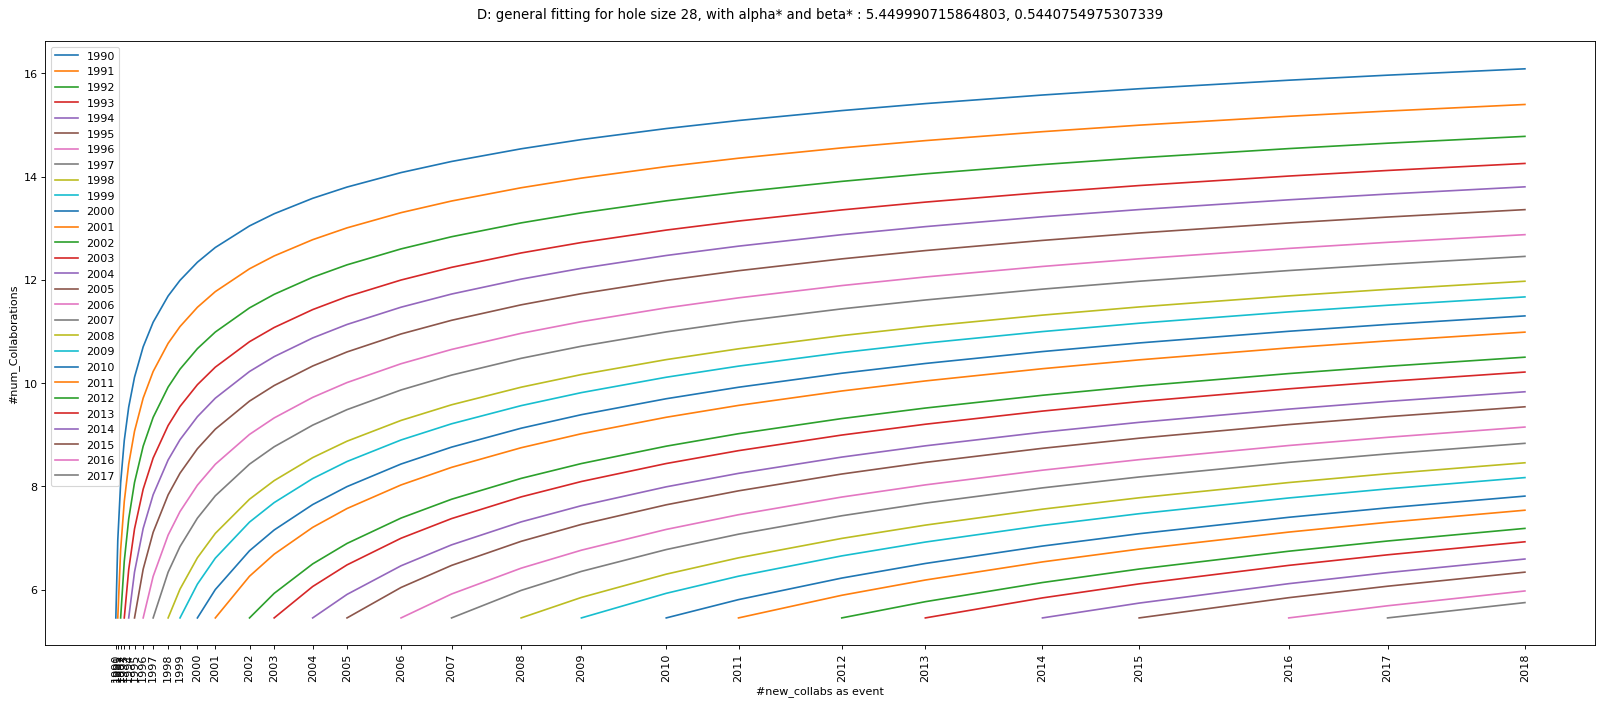

In [316]:
## Plot above calculated functions  
for i in range(len(error_f_labels)):
    plt.figure(figsize=(25, 10), dpi=80)
    plt.title(error_f_labels[i] + ": general fitting for hole size " + str(HOLE_SIZE) + ", with alpha* and beta* : " + str(alphas_opt[i]) + ", " + str(betas_opt[i]) + "\n", fontdict = {'fontsize' : 12})
    plt.xlabel("#new_collabs as event")
    plt.ylabel("#num_Collaborations")
    plt.xticks(rotation='vertical')

    for start_y in YEARS[:-1]:
        j = YEARS.index(start_y)
        x = get_avg_trajectories(events, HOLE_SIZE, start_y)[0]
        plt.plot(x,error_fit_functions[error_f_labels[i]][j])
        
    plt.xticks(rotation='vertical')    
    plt.legend(YEARS, loc='upper left')
    plt.xticks(events, YEARS)
    plt.show()

# **(4) Shift fitted trajectories, compute their average and fit it**

<center><img src="./assets/4.png" style="width: 600px;"></center>

In [338]:
# Shift all fitted trajectories
shifted_funcs = []
for i in range(len(alphas)):
    
    events_plus1 = [1]
    for e in events:
        events_plus1.append(e)
        
    f = func(events_plus1, alphas[i], betas[i], np.int64(1))
    #plt.plot(a, f)
    shifted_funcs.append(f) # add function to the set

In [339]:
# compute the average of the shifted functions
avg_shift = np.average(np.array(shifted_funcs), axis=0)

In [340]:
# fit the average curve
fit_avg_shift , alpha, beta = fit_trajectory(events_plus1, avg_shift,  np.int64(1)) # you cannot start from event 0

print("The fitted parameters are:")
print(" alpha*:", alpha, "\n beta*:", beta)

The fitted parameters are:
 alpha*: 2.0484705597132558 
 beta*: 1.6810767491988743


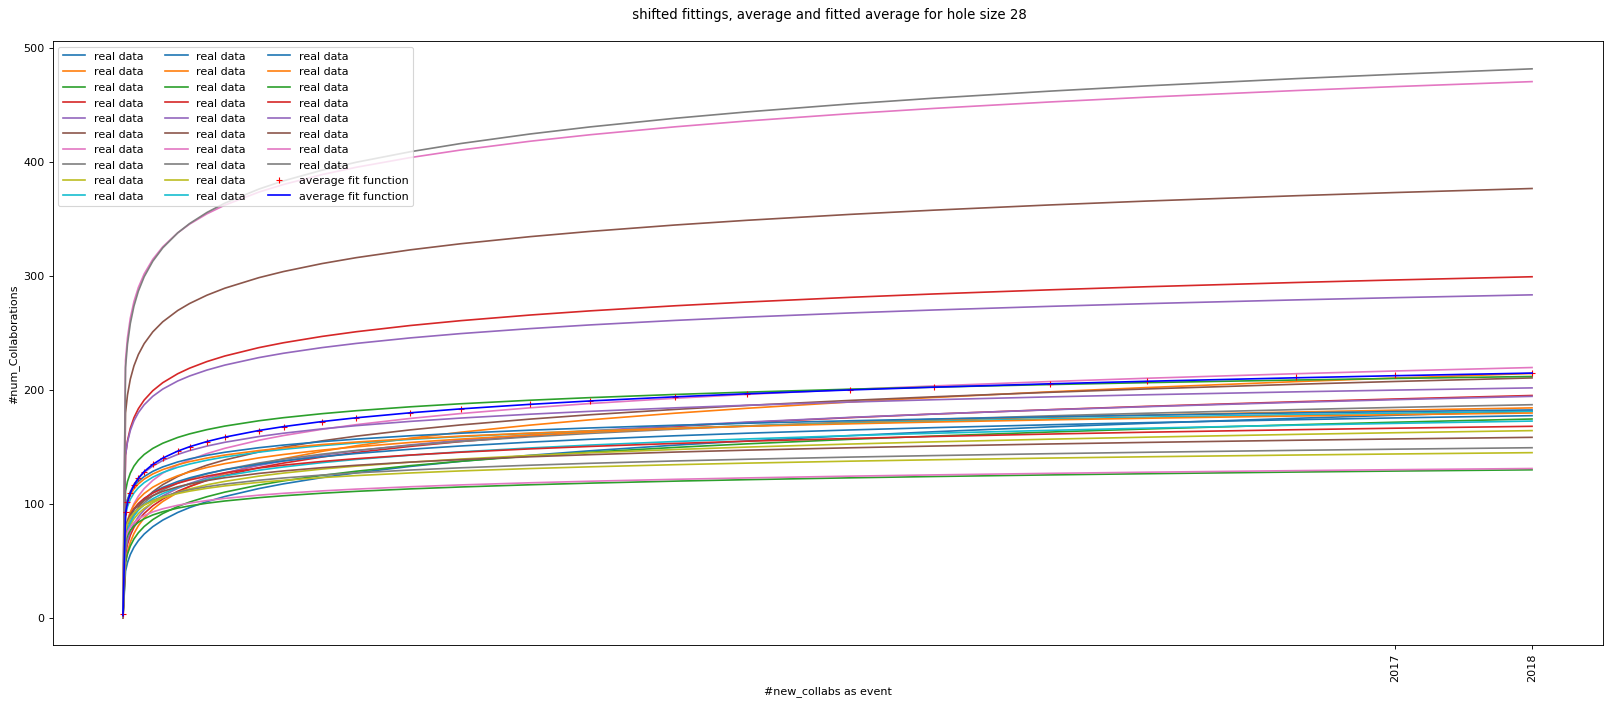

In [353]:
plt.figure(figsize=(25, 10), dpi=80)
plt.title(" shifted fittings, average and fitted average for hole size "+ str(HOLE_SIZE) +  "\n", fontdict = {'fontsize' : 12})
plt.xlabel("#new_collabs as event")
plt.ylabel("#num_Collaborations")
plt.xticks(rotation='vertical')

for start_y in YEARS[:-1]:

    j = YEARS.index(start_y)
    

    plt.plot(events_plus1,shifted_funcs[j], label="real data")
plt.plot(events_plus1, avg_shift, 'r+', label="average fit function")
plt.plot(events_plus1, fit_avg_shift, 'b-', label="average fit function")

plt.xticks(rotation='vertical')    
plt.legend(loc='upper left', ncol=3)
plt.xticks(x, YEARS[j:])
plt.show()

In [341]:
## get general fitting functions for each starting year for alpha* and beta* of the fitted average
average_fit_functions = [] # contains fitted error functions for each year 
for start_y in YEARS[:-1]:
    curr_x = events[YEARS.index(start_y)]  
    x,y = get_avg_trajectories(events, HOLE_SIZE, start_y) # retrieve average trajecory for the given start_y (and hole size) 
    
    general_fit_y = func(x, alpha, beta, curr_x)
    average_fit_functions.append(general_fit_y)

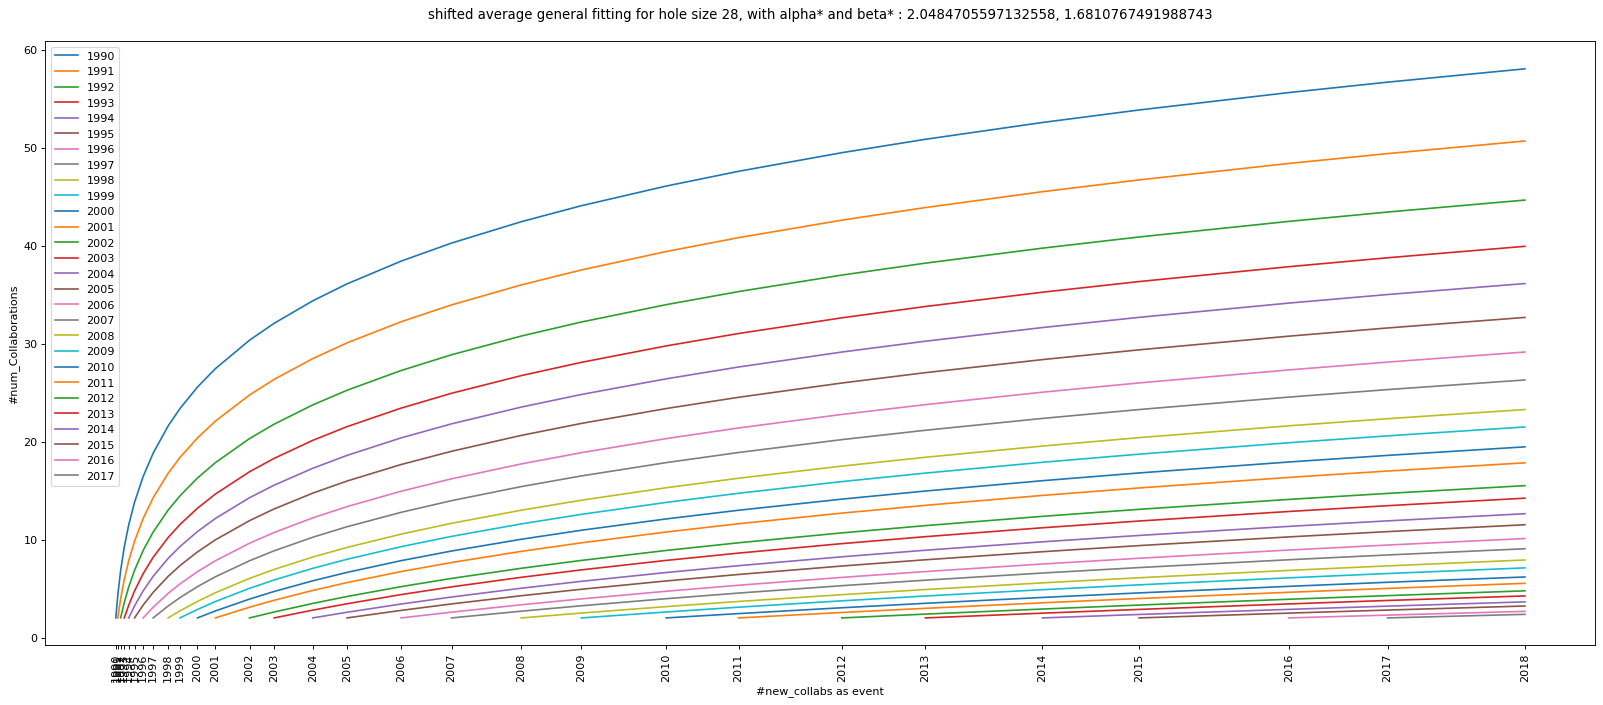

In [342]:
## Plot above calculated functions  
plt.figure(figsize=(25, 10), dpi=80)
plt.title("shifted average general fitting for hole size " + str(HOLE_SIZE) + ", with alpha* and beta* : " + str(alpha) + ", " + str(beta) + "\n", fontdict = {'fontsize' : 12})
plt.xlabel("#new_collabs as event")
plt.ylabel("#num_Collaborations")
plt.xticks(rotation='vertical')

for start_y in YEARS[:-1]:
    j = YEARS.index(start_y)
    x = get_avg_trajectories(events, HOLE_SIZE, start_y)[0]
    plt.plot(x,average_fit_functions[j])    
     
plt.xticks(rotation='vertical')    
plt.legend(YEARS, loc='upper left', ncols=2)
plt.xticks(events, YEARS)
plt.show()

# **(5) compare general fitting error functions A,B,C and D with the general average fitted one**  

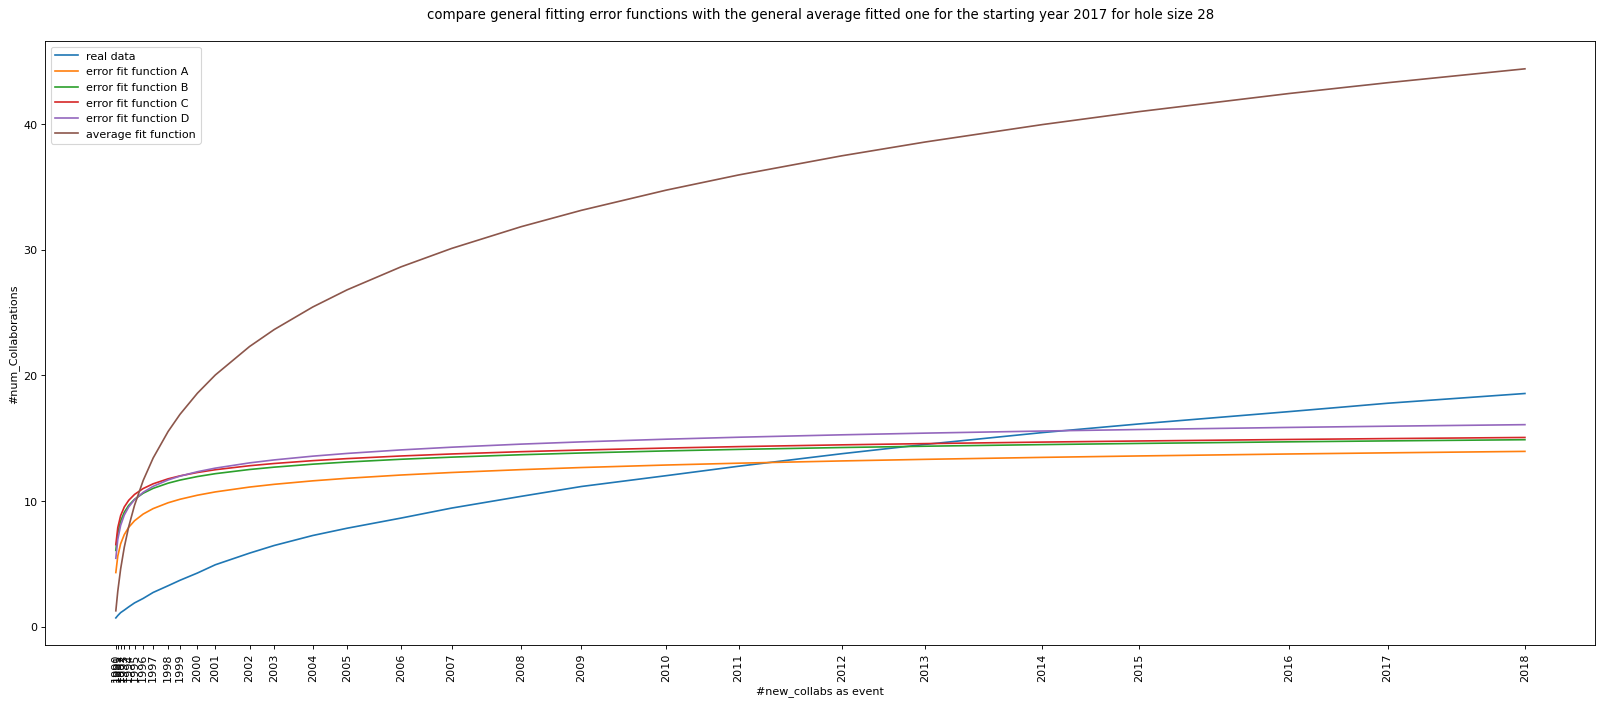

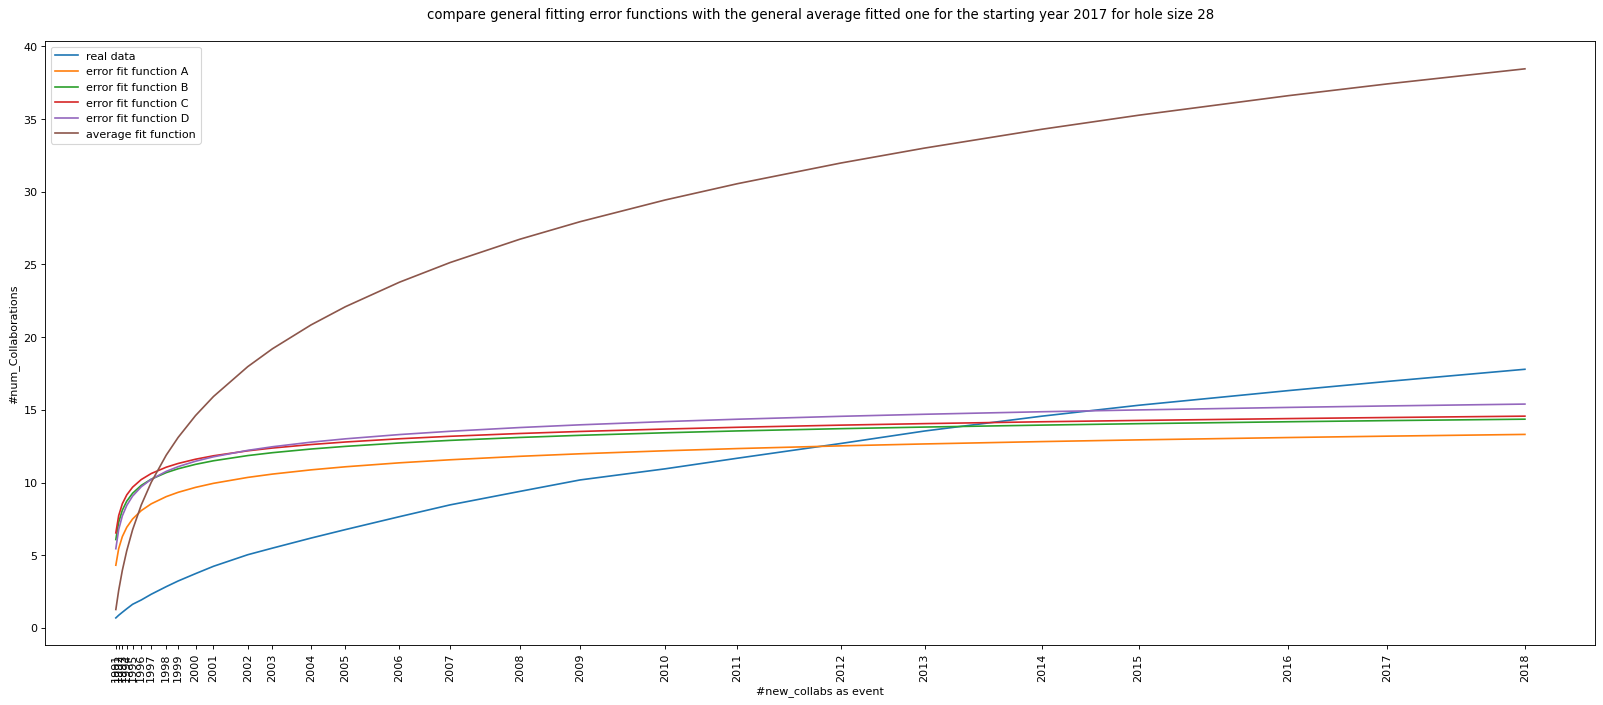

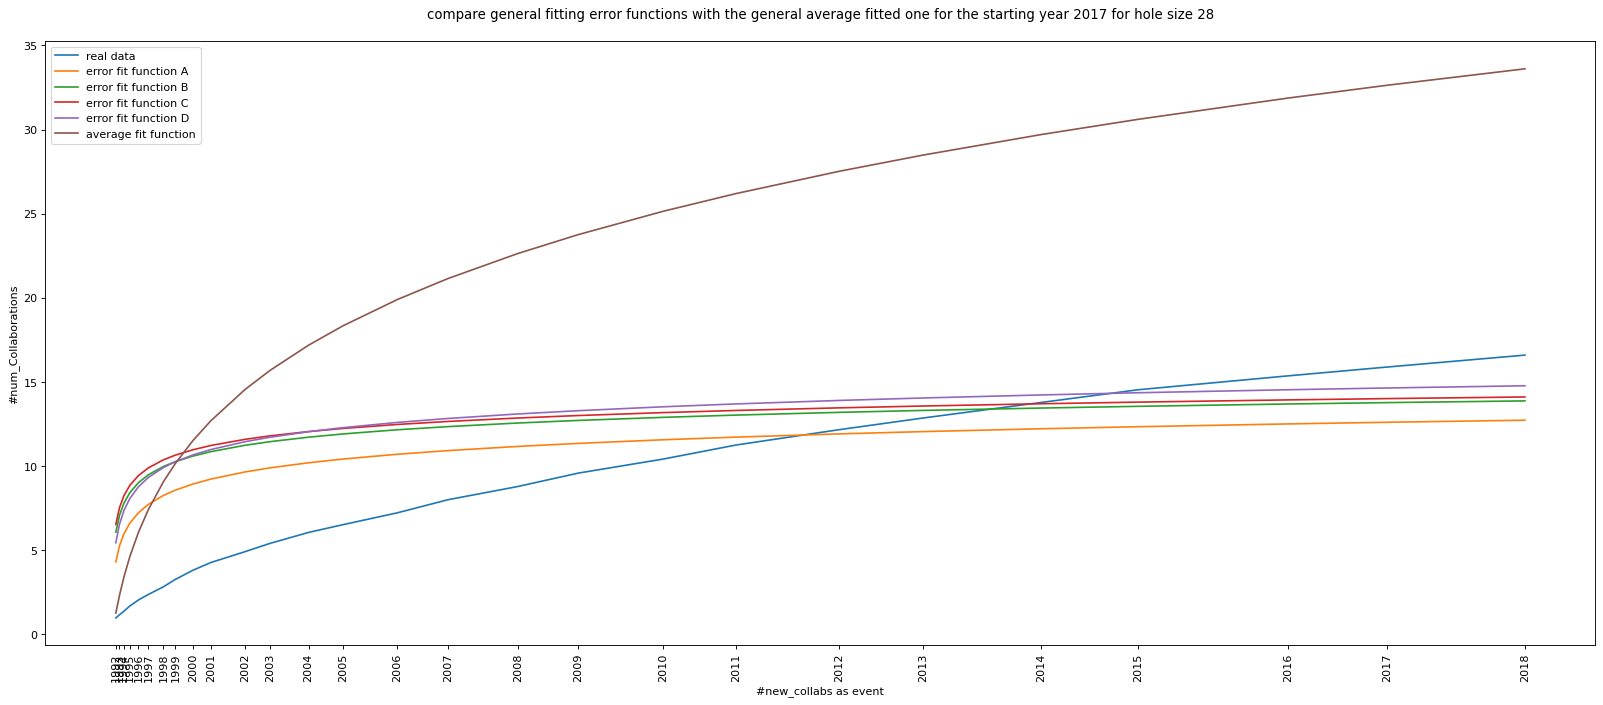

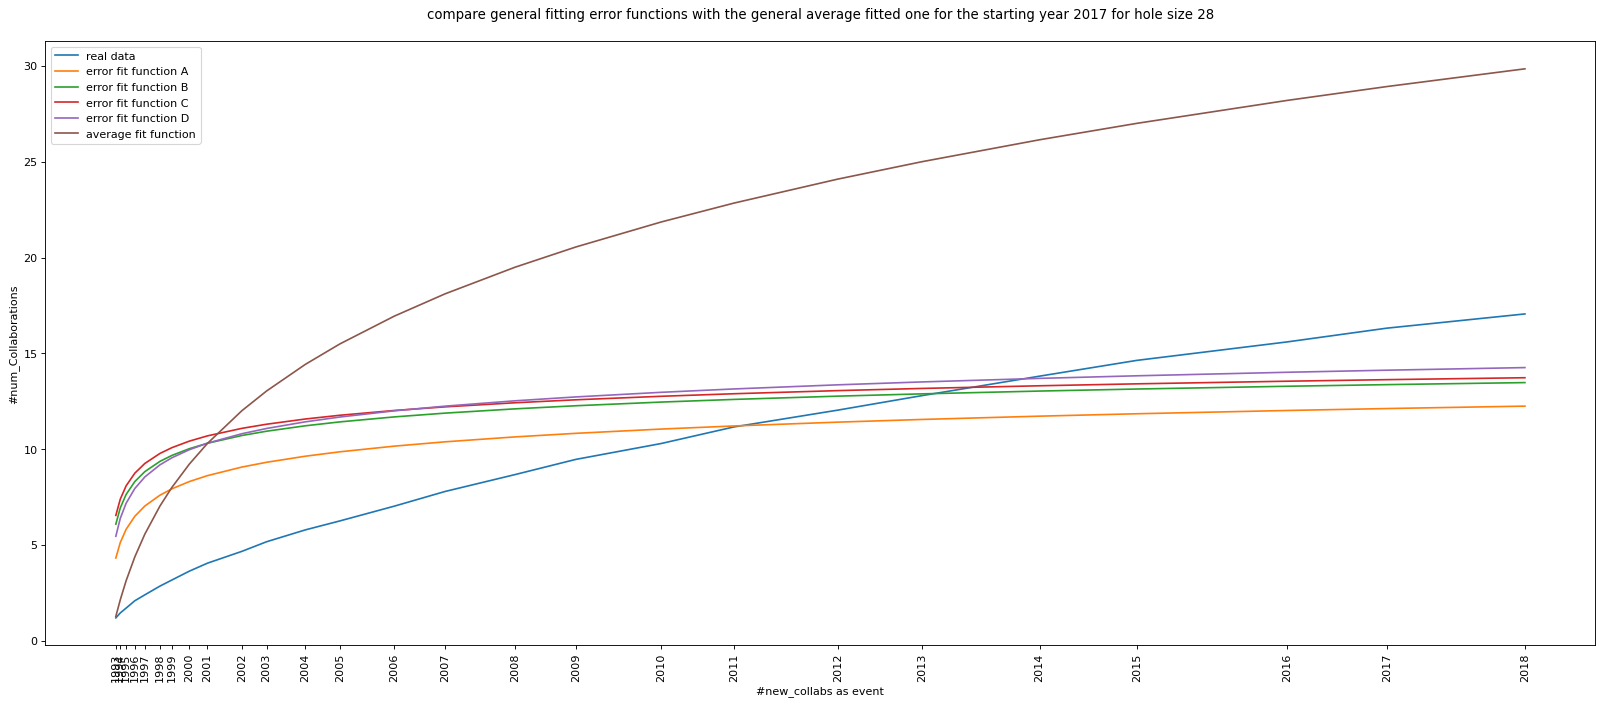

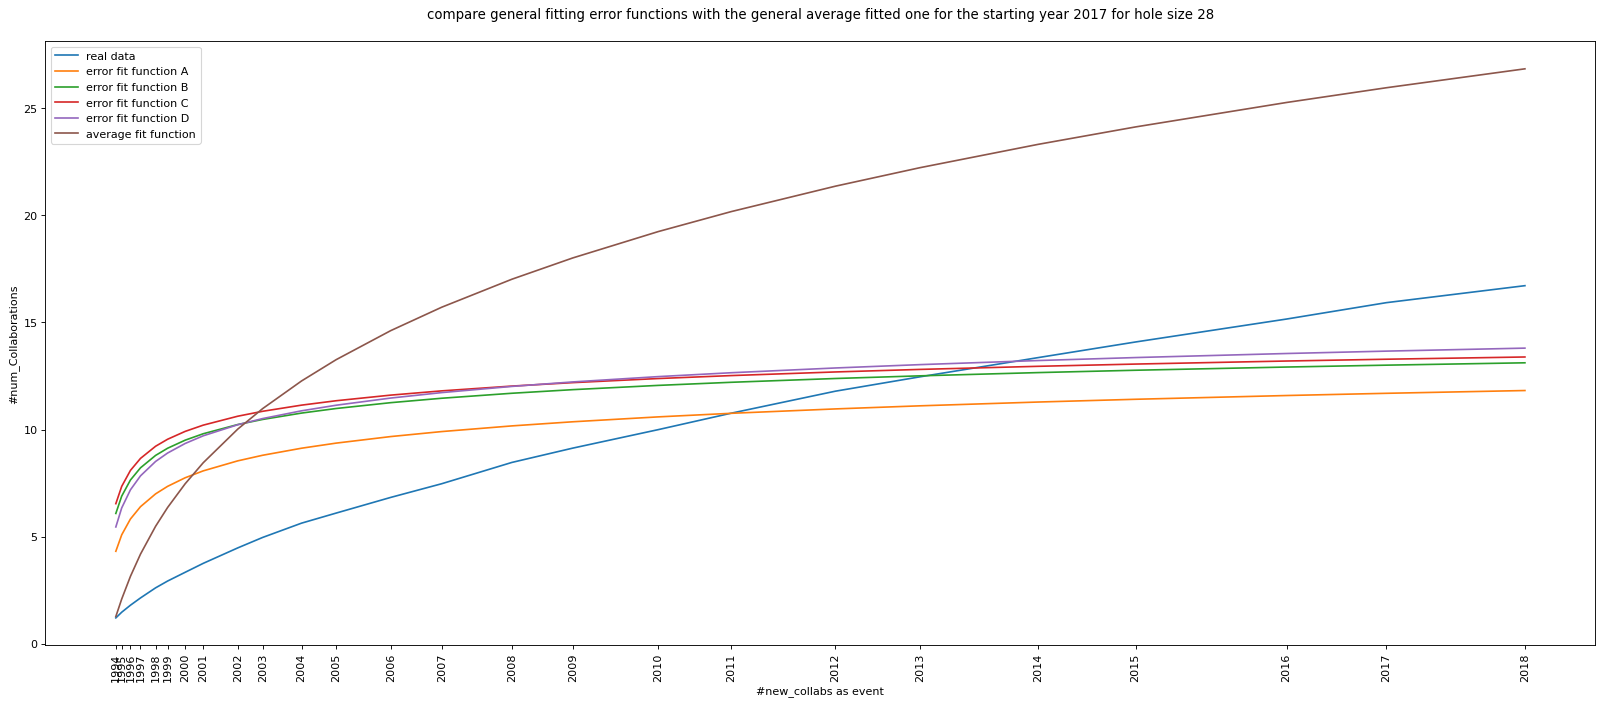

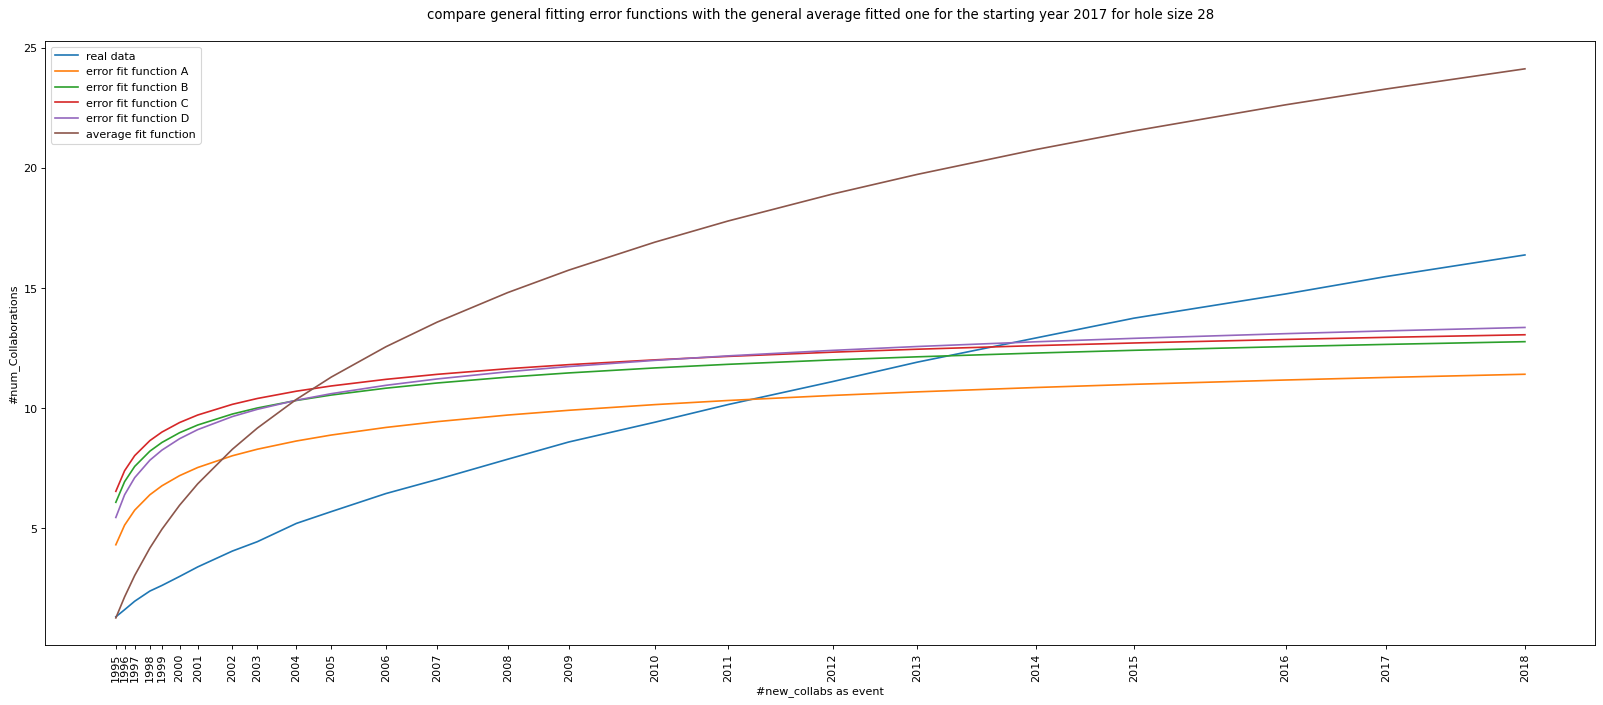

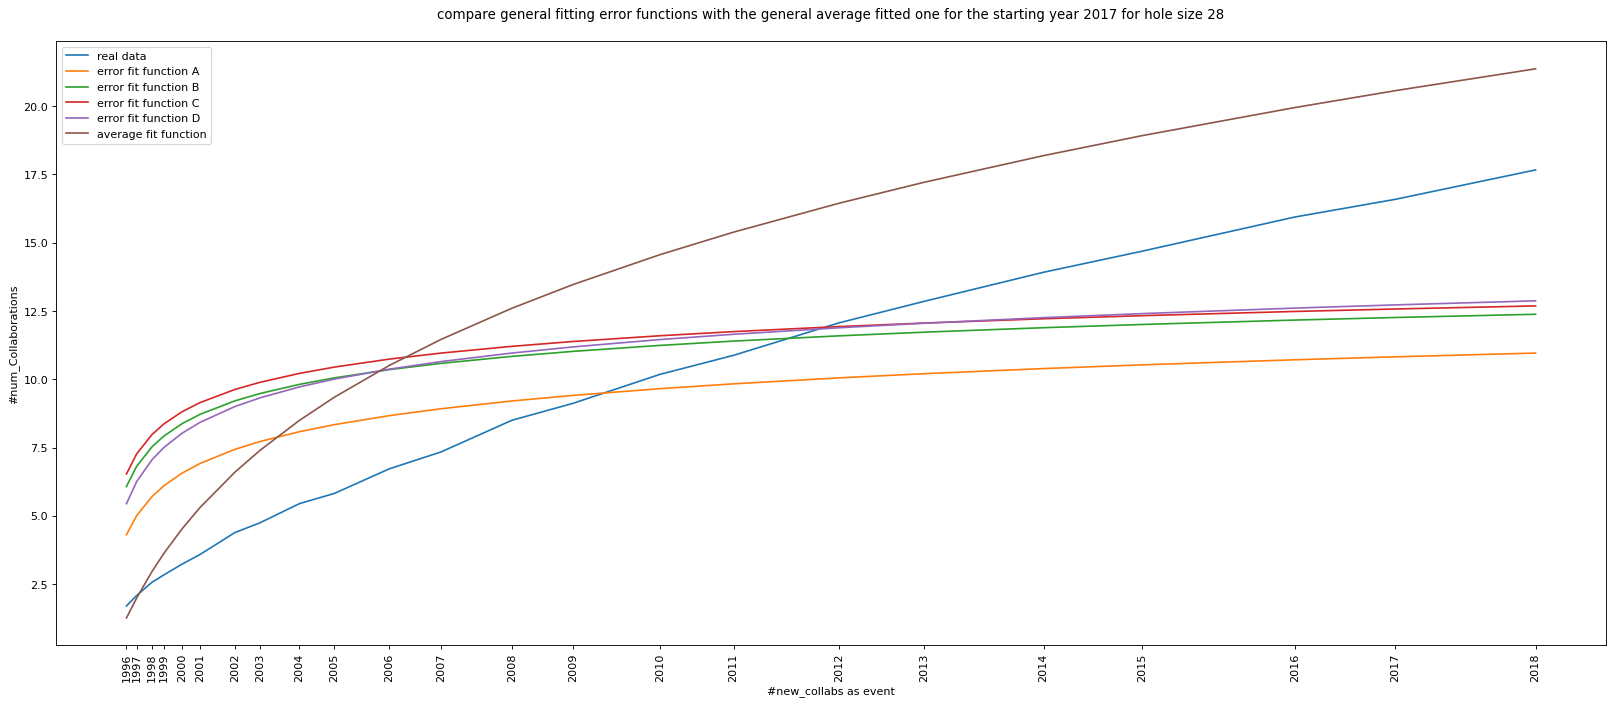

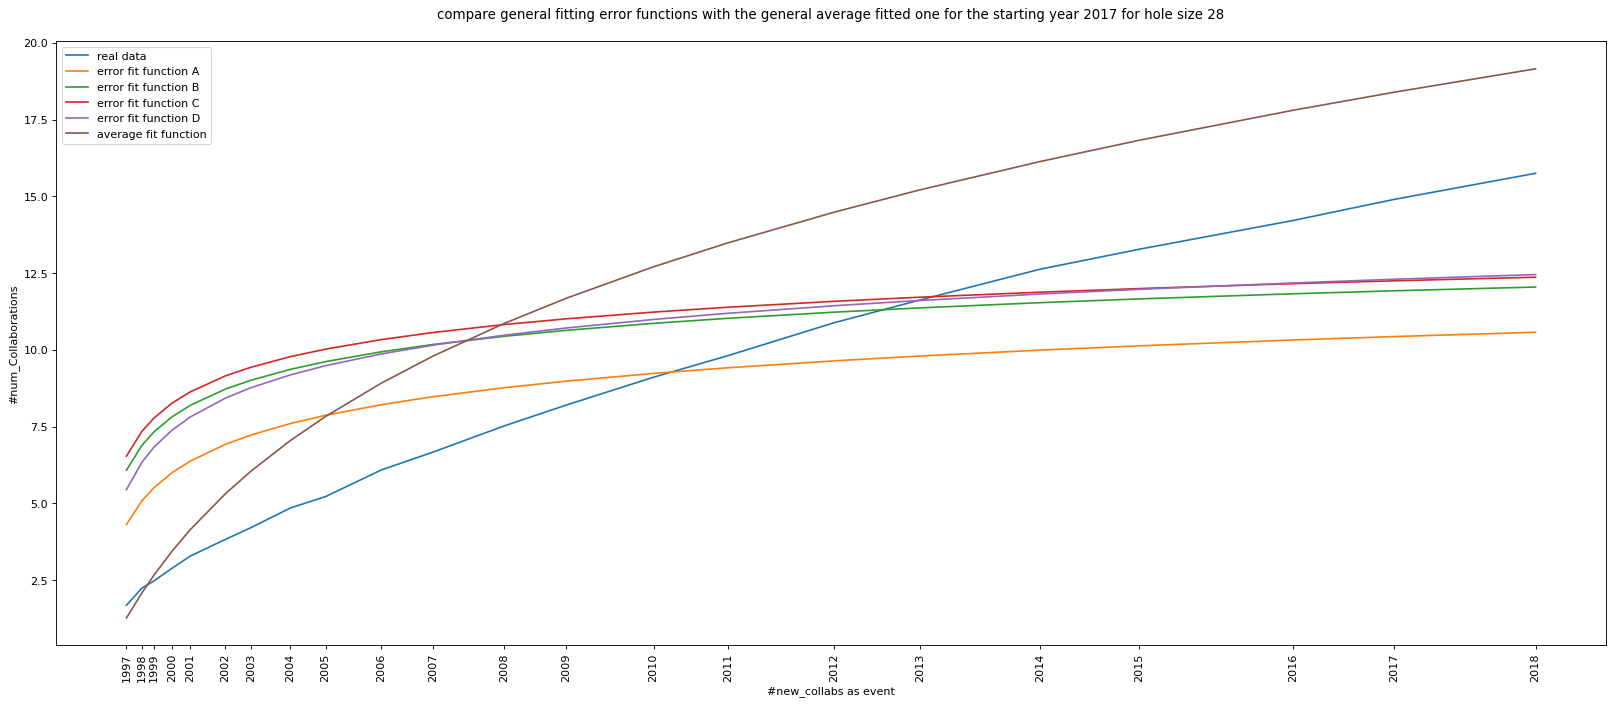

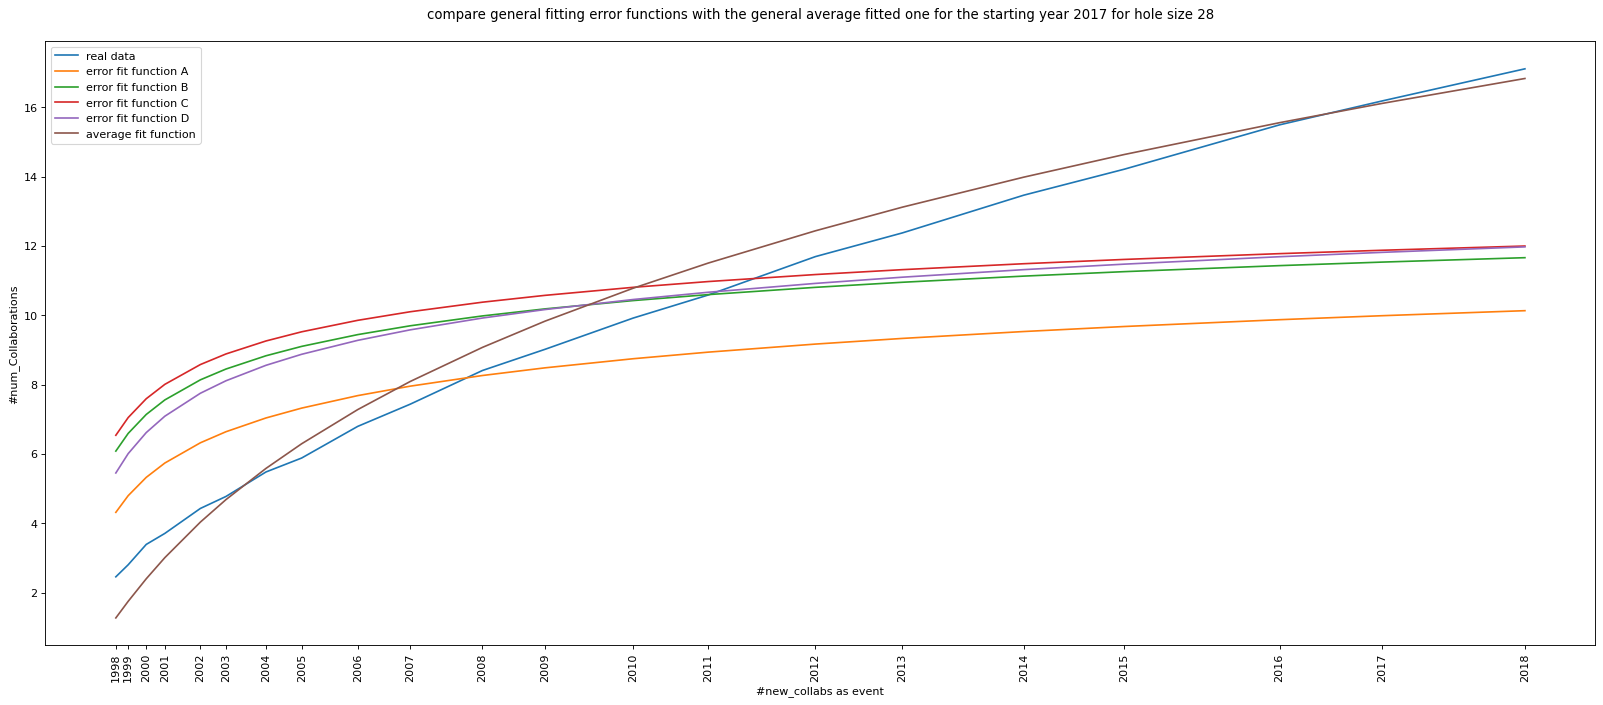

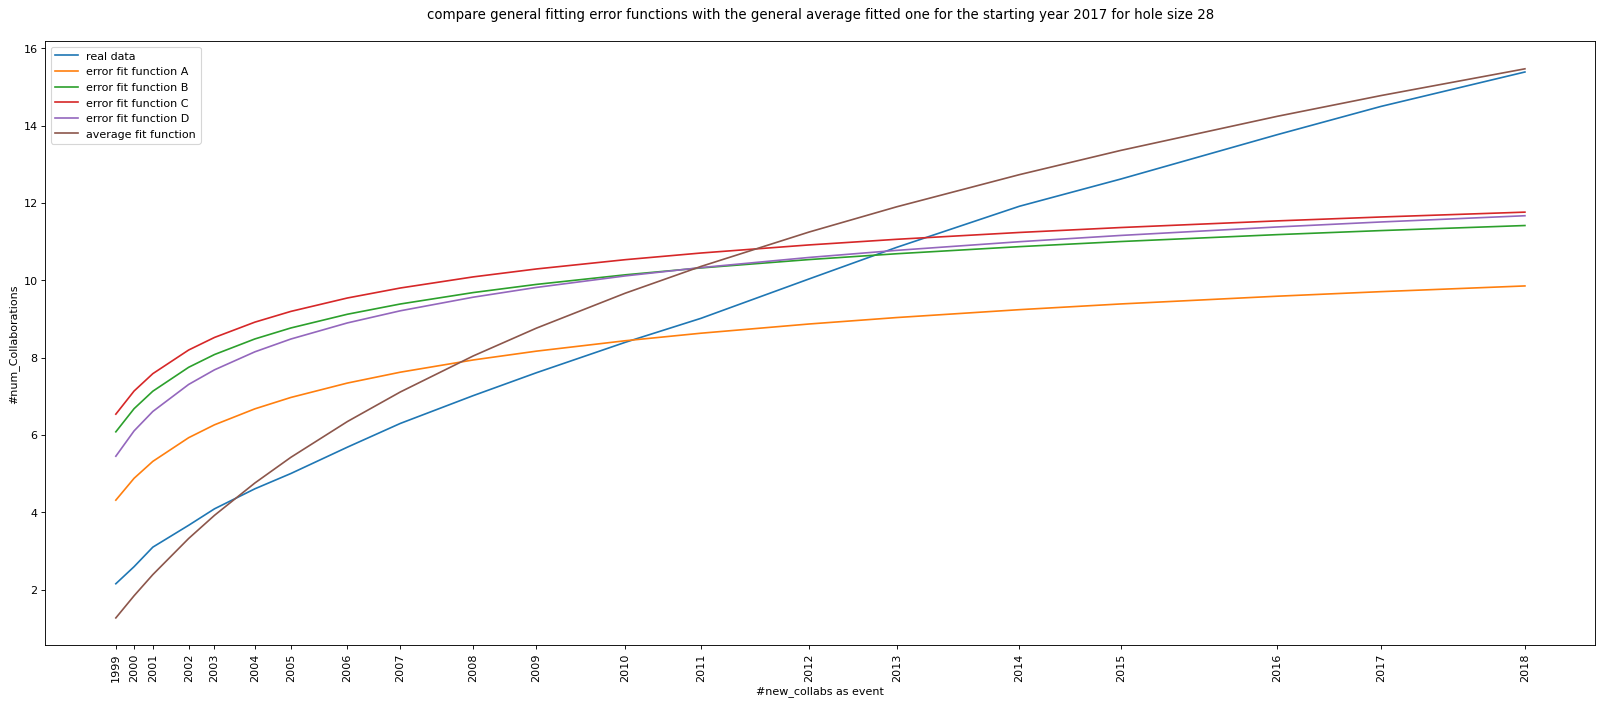

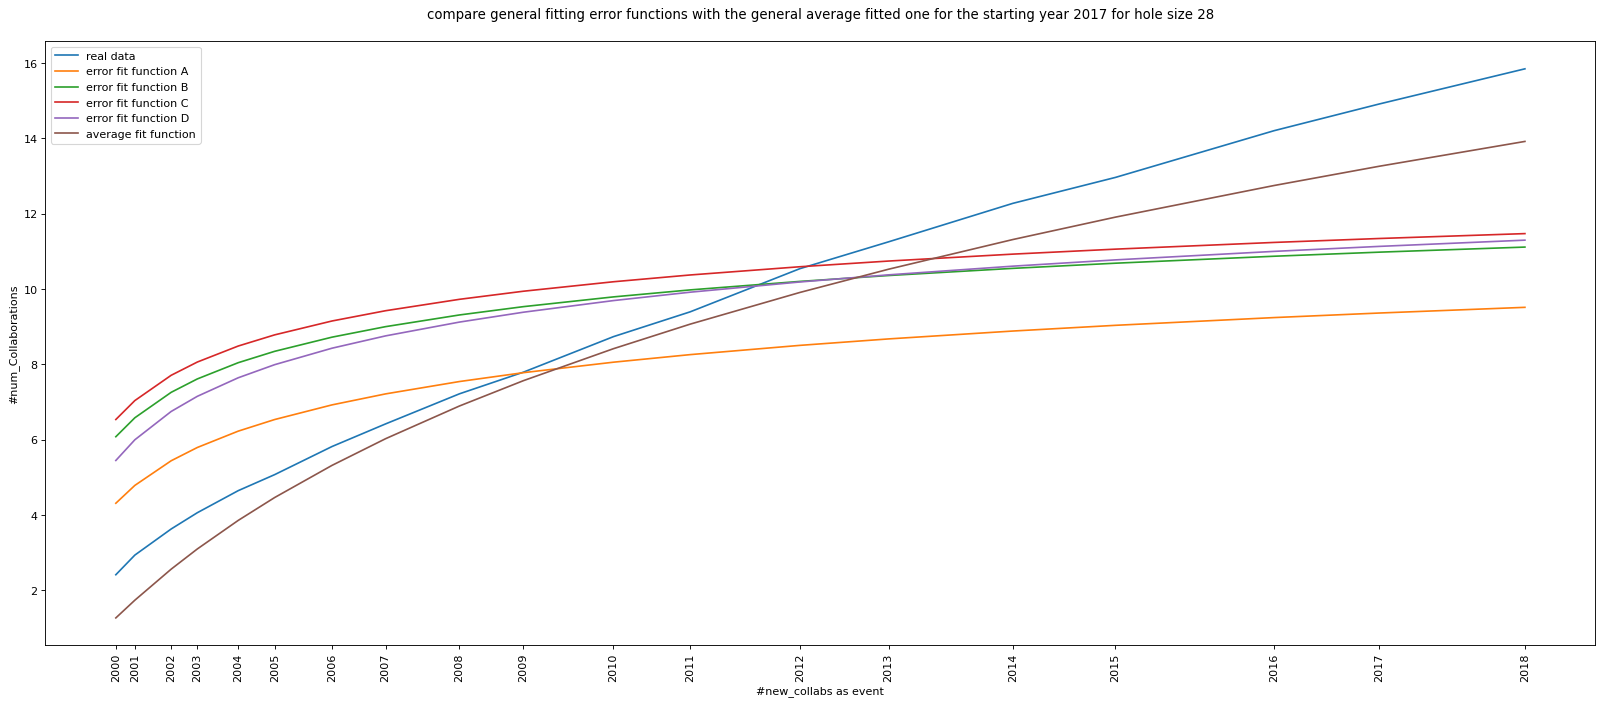

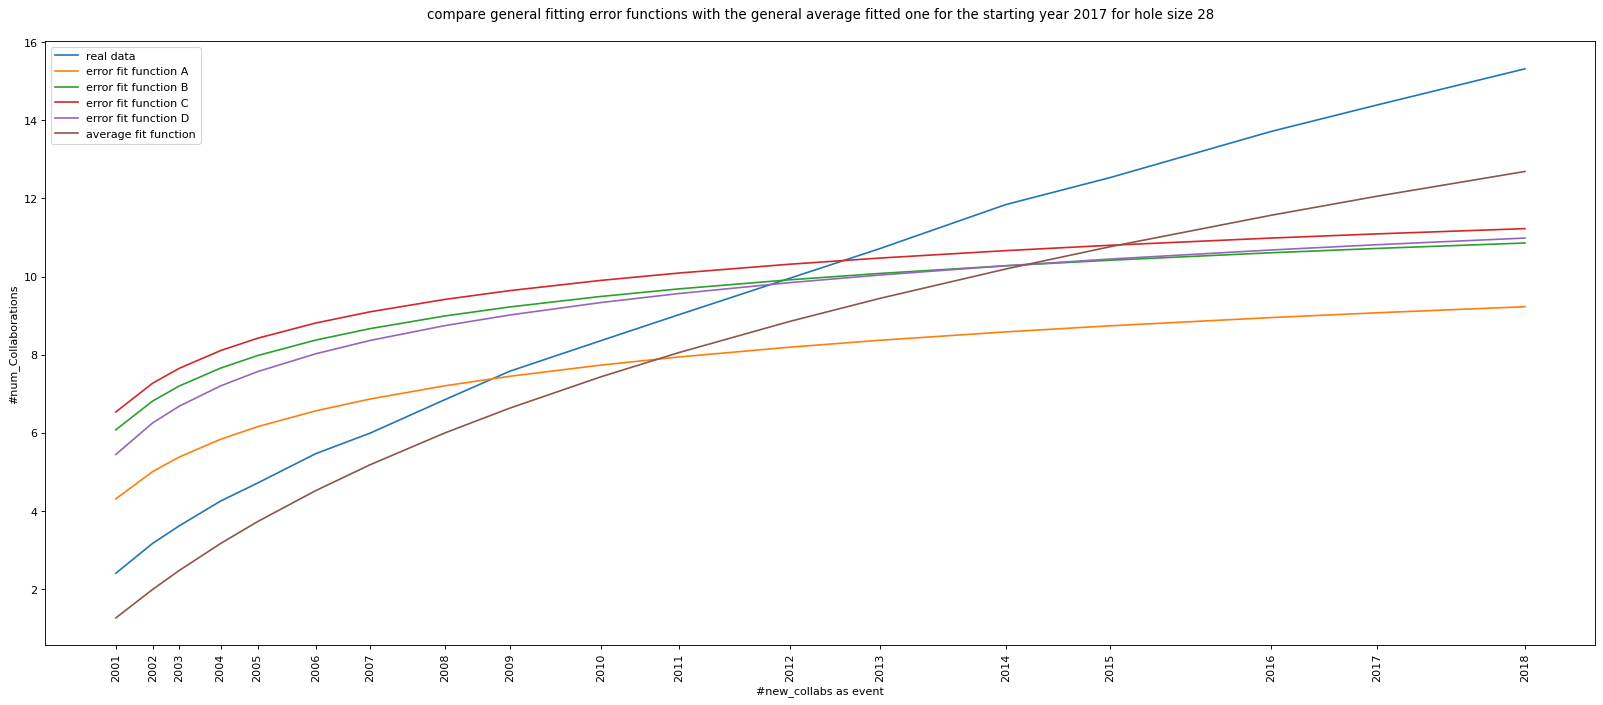

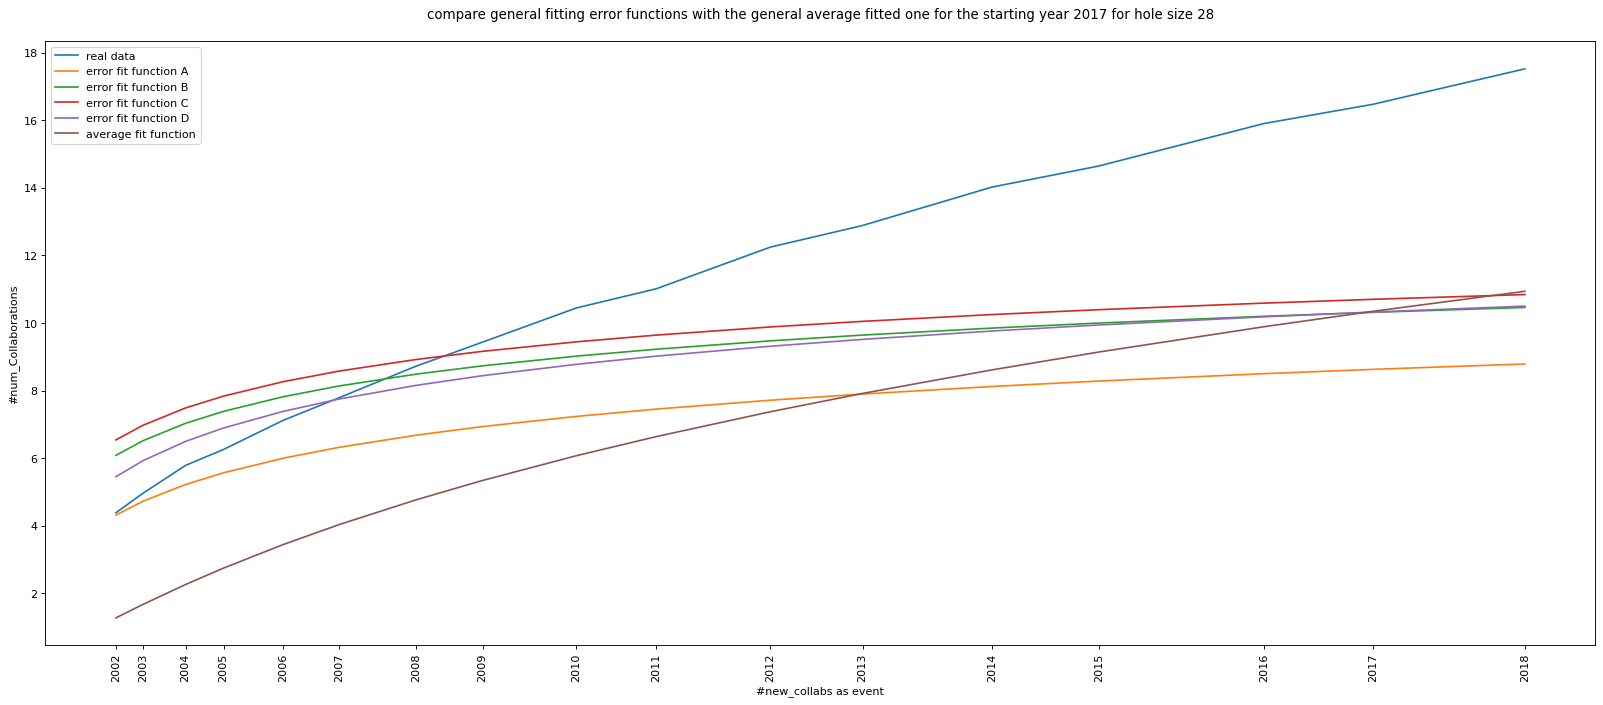

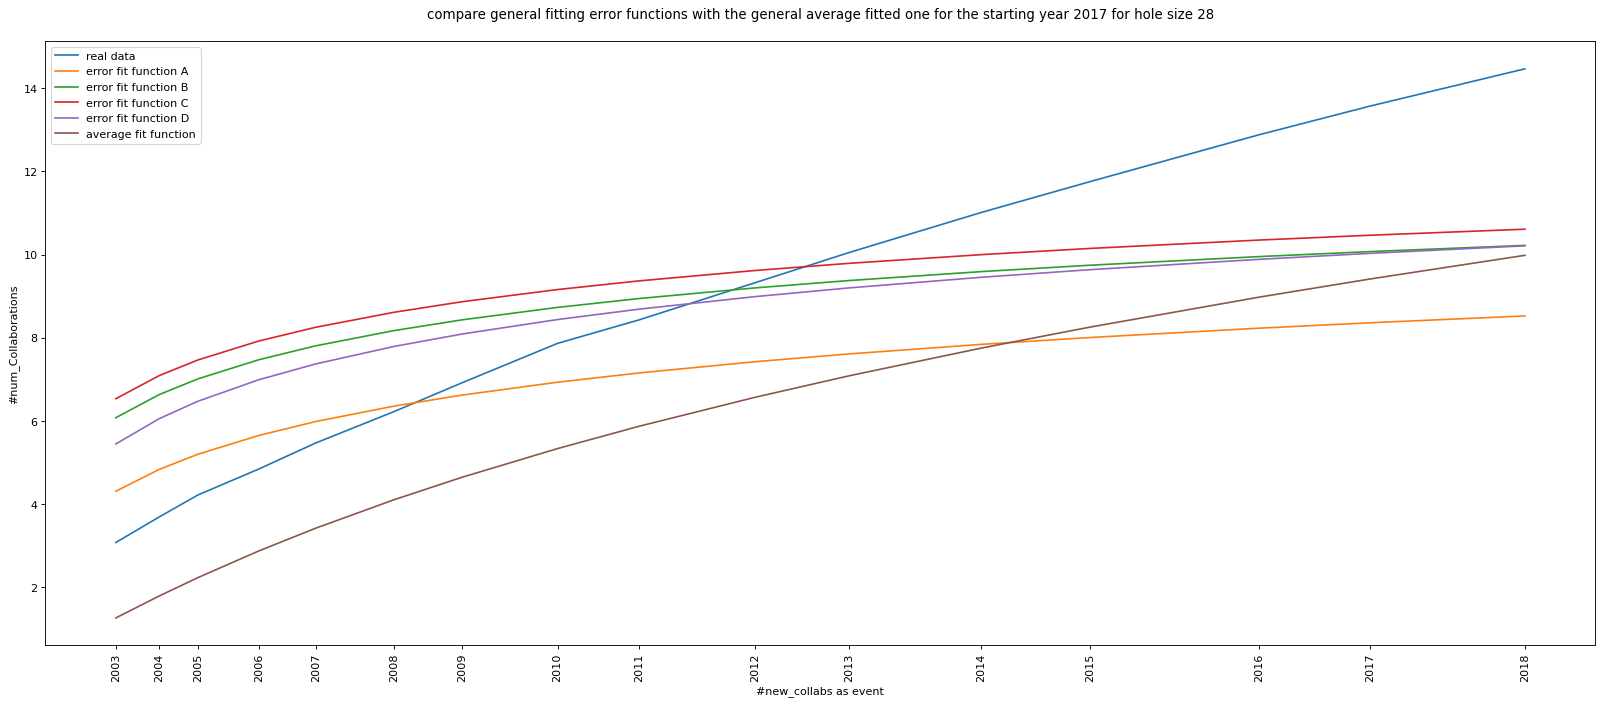

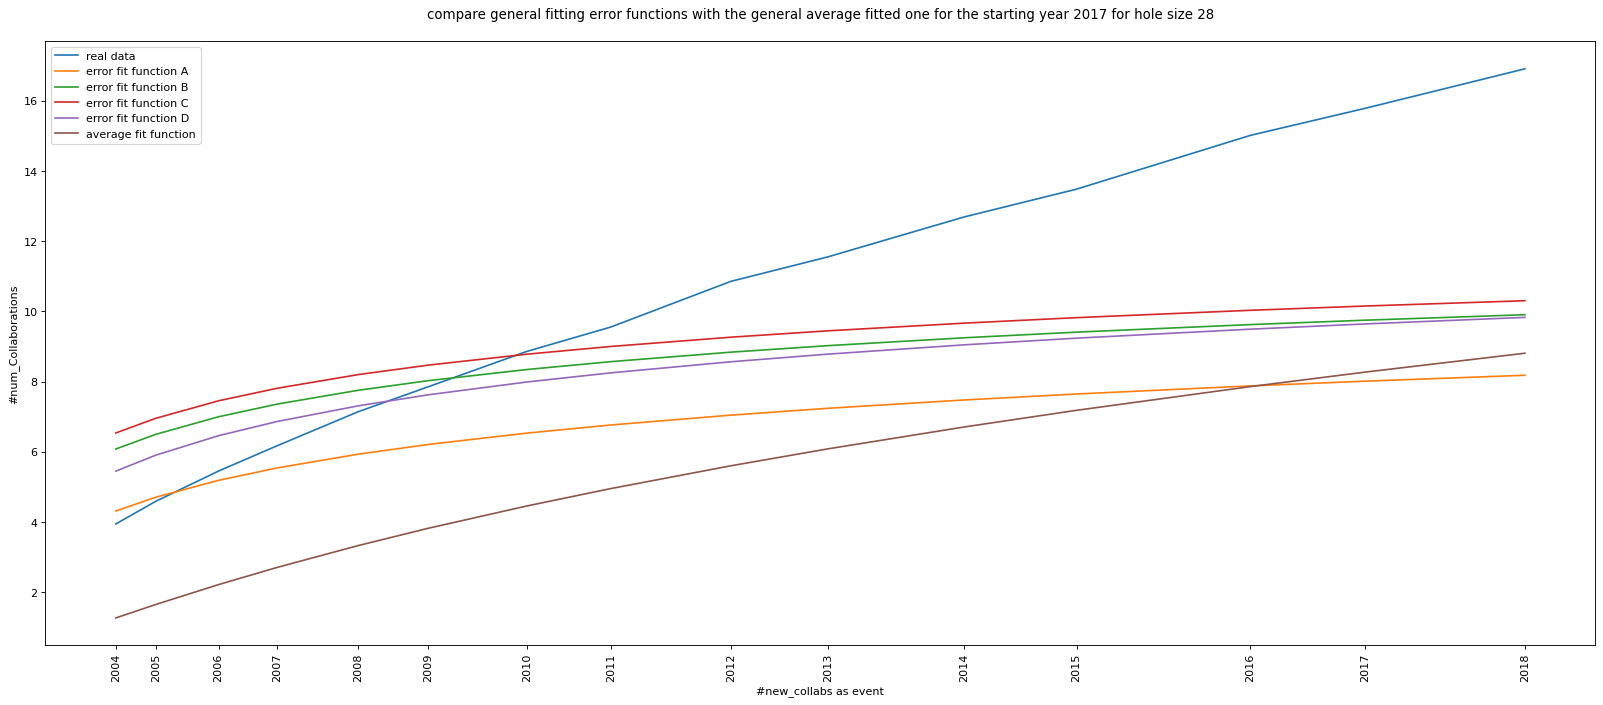

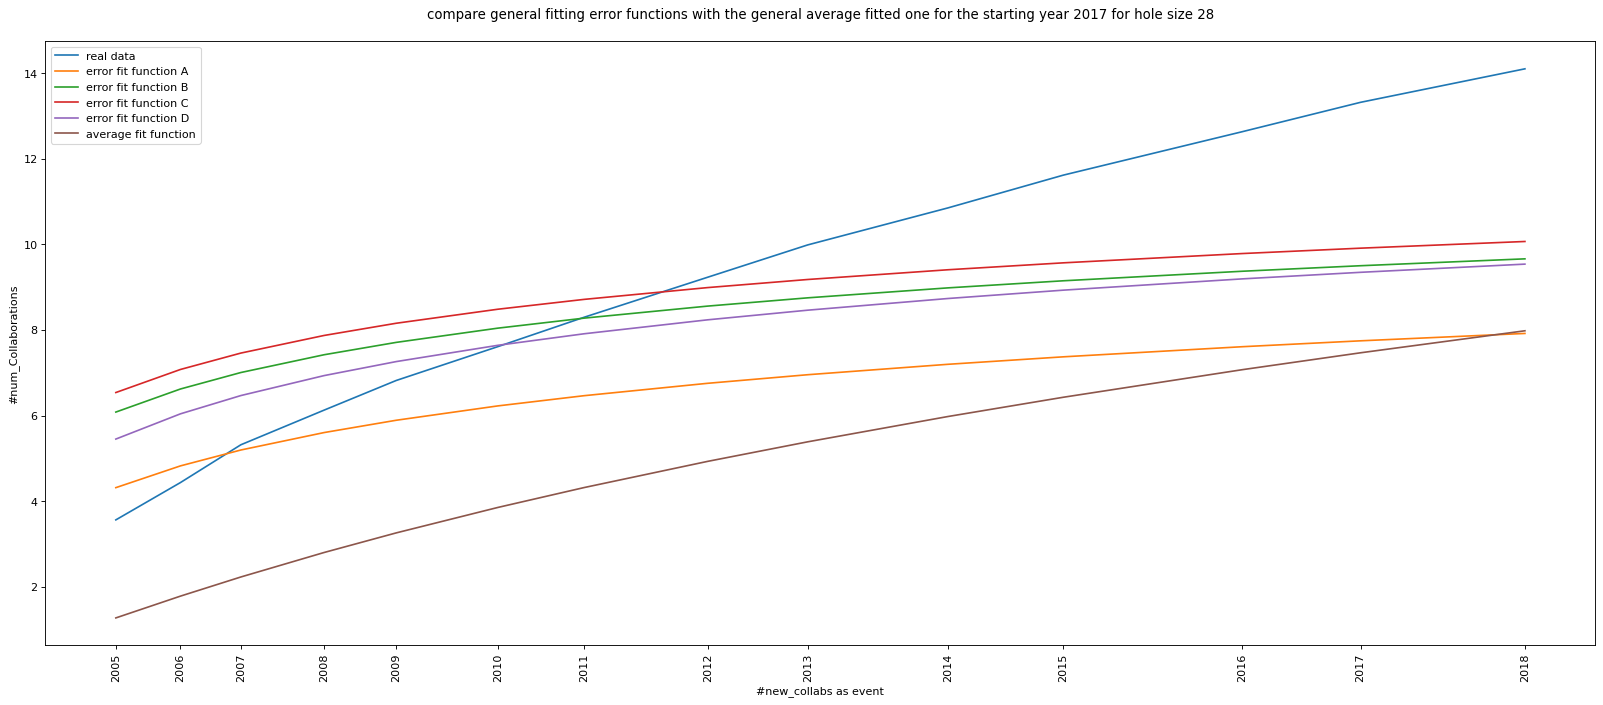

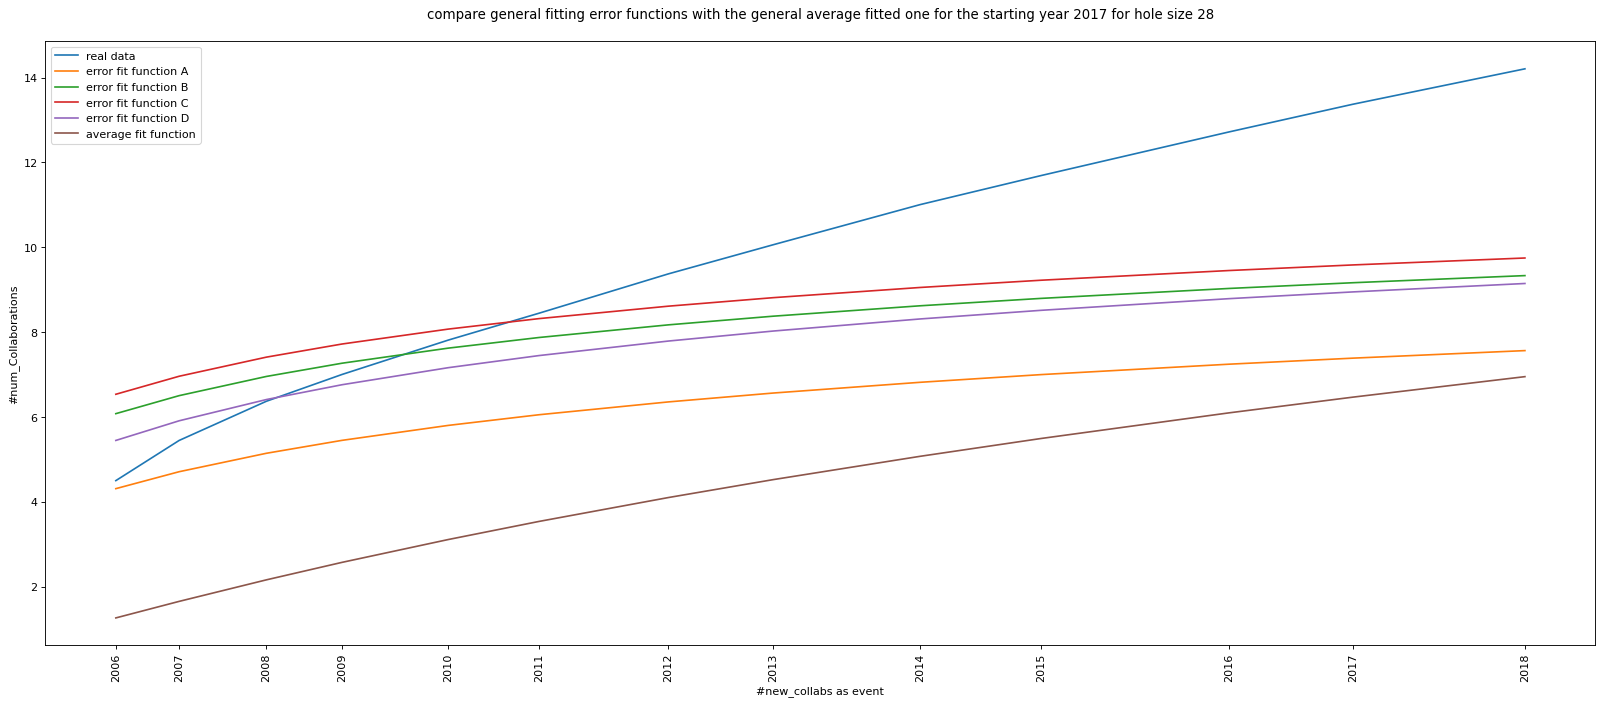

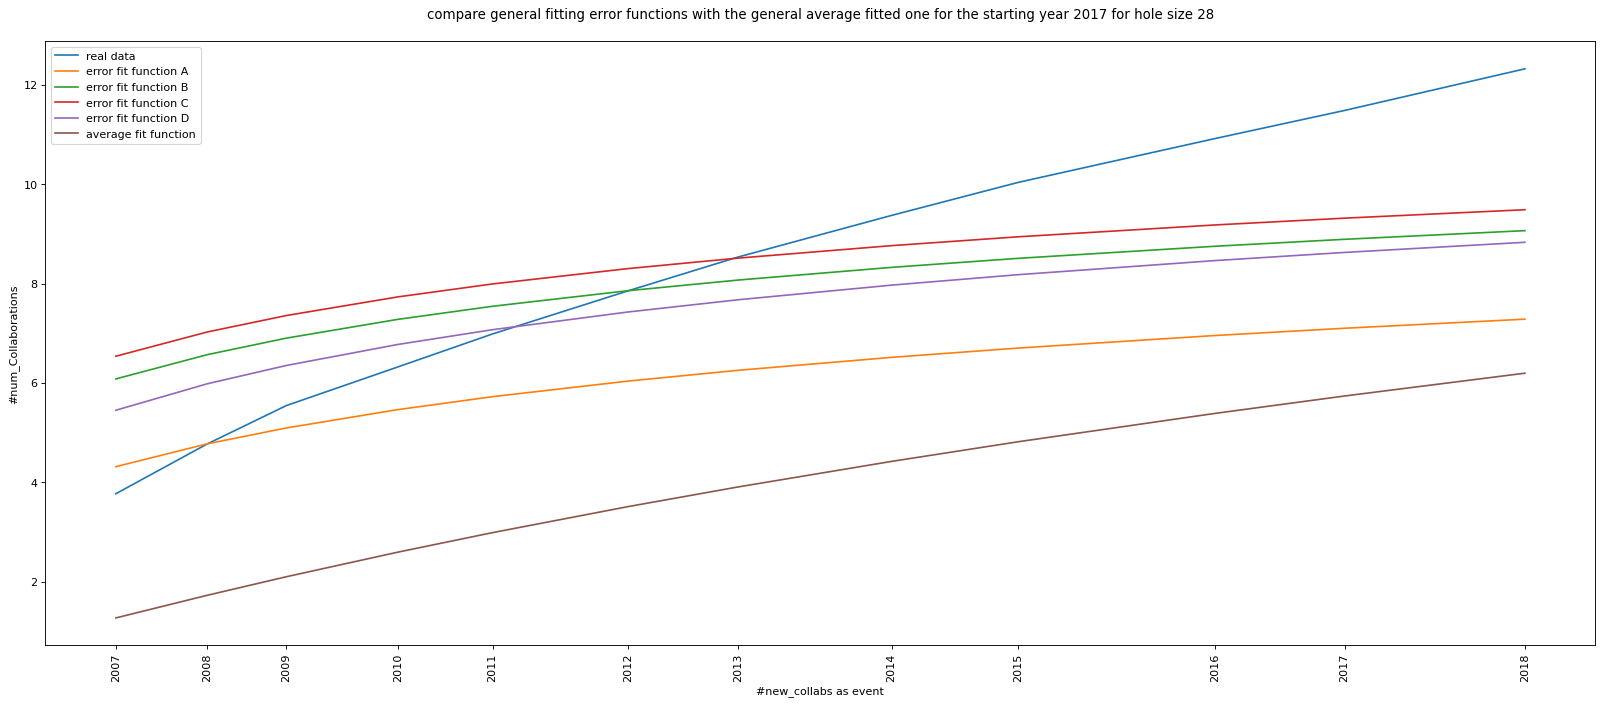

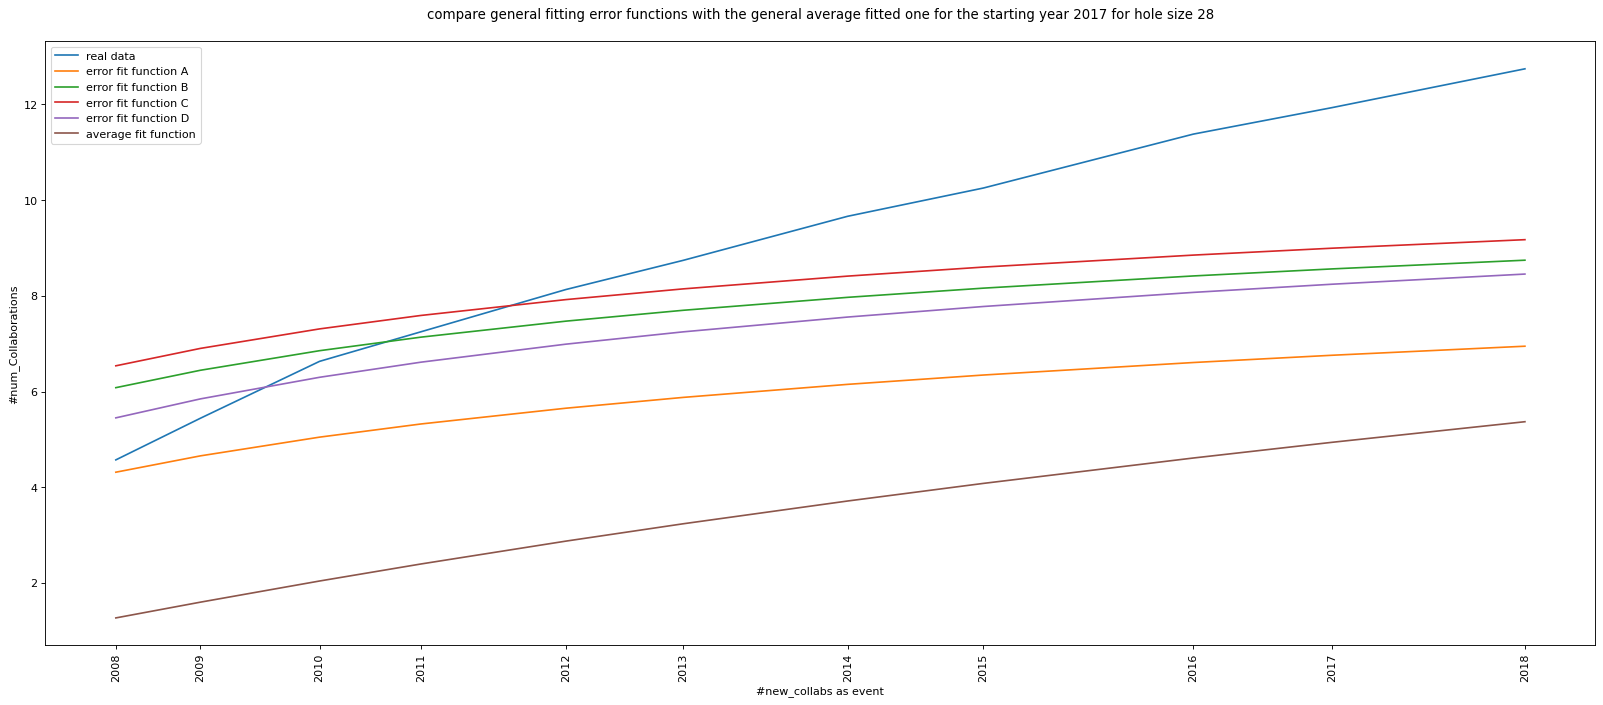

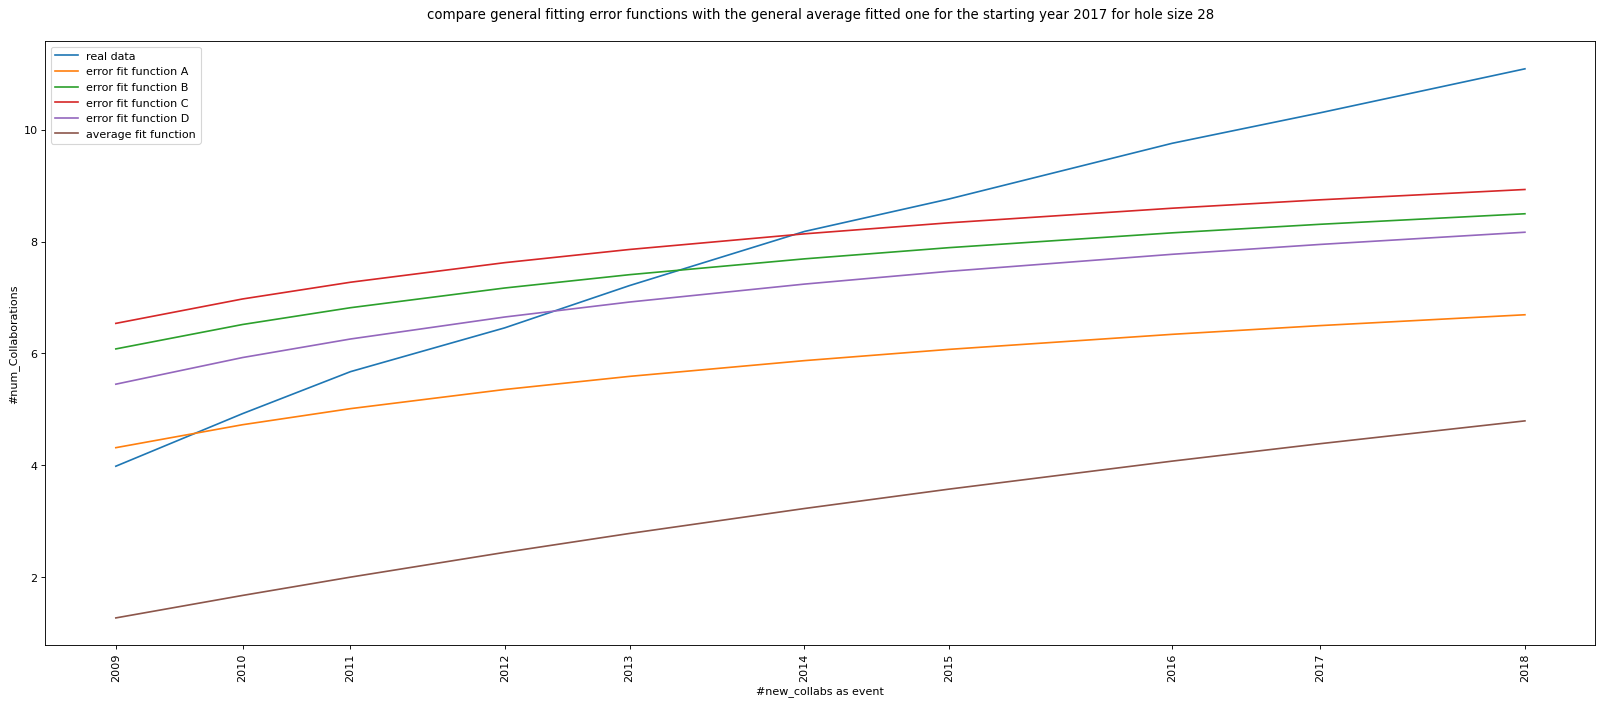

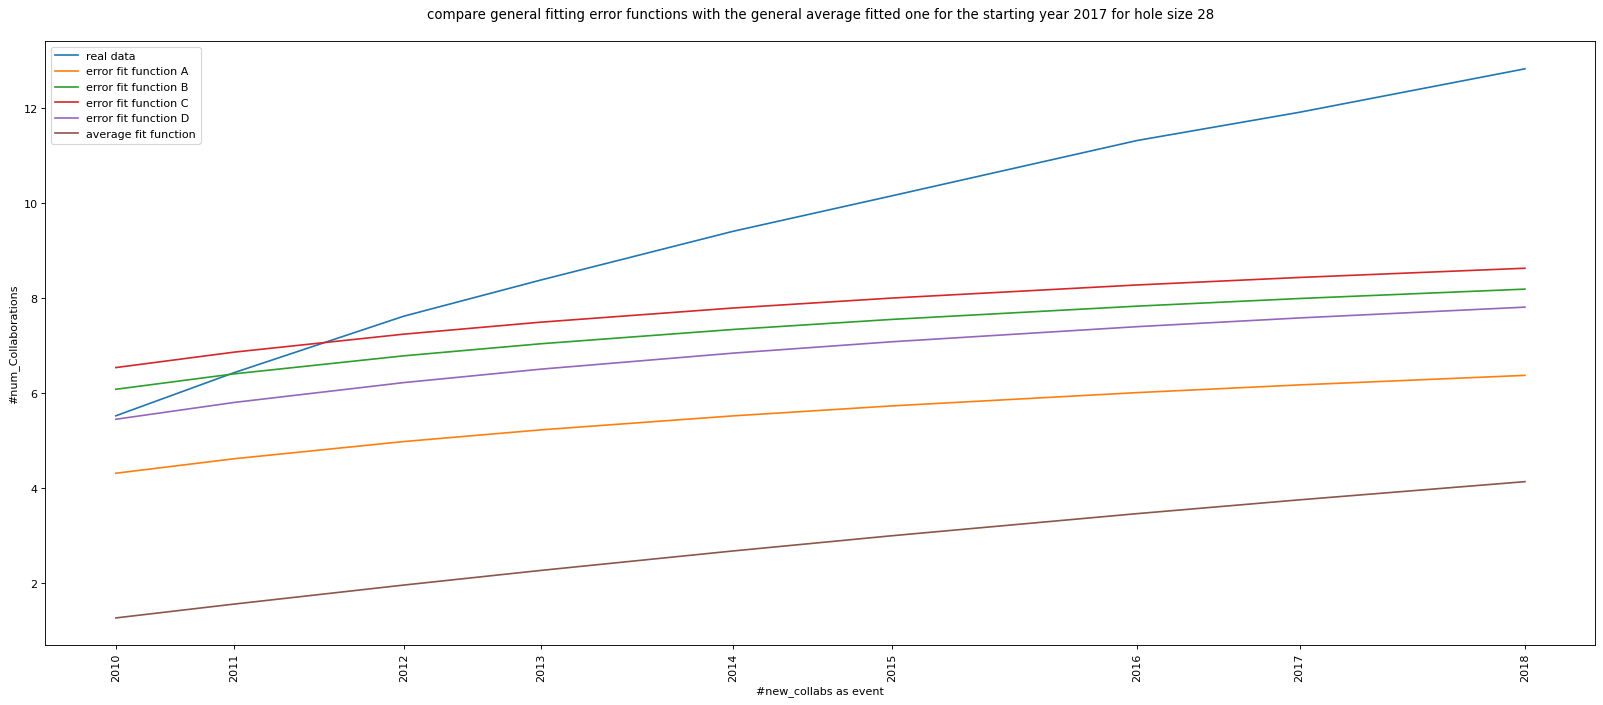

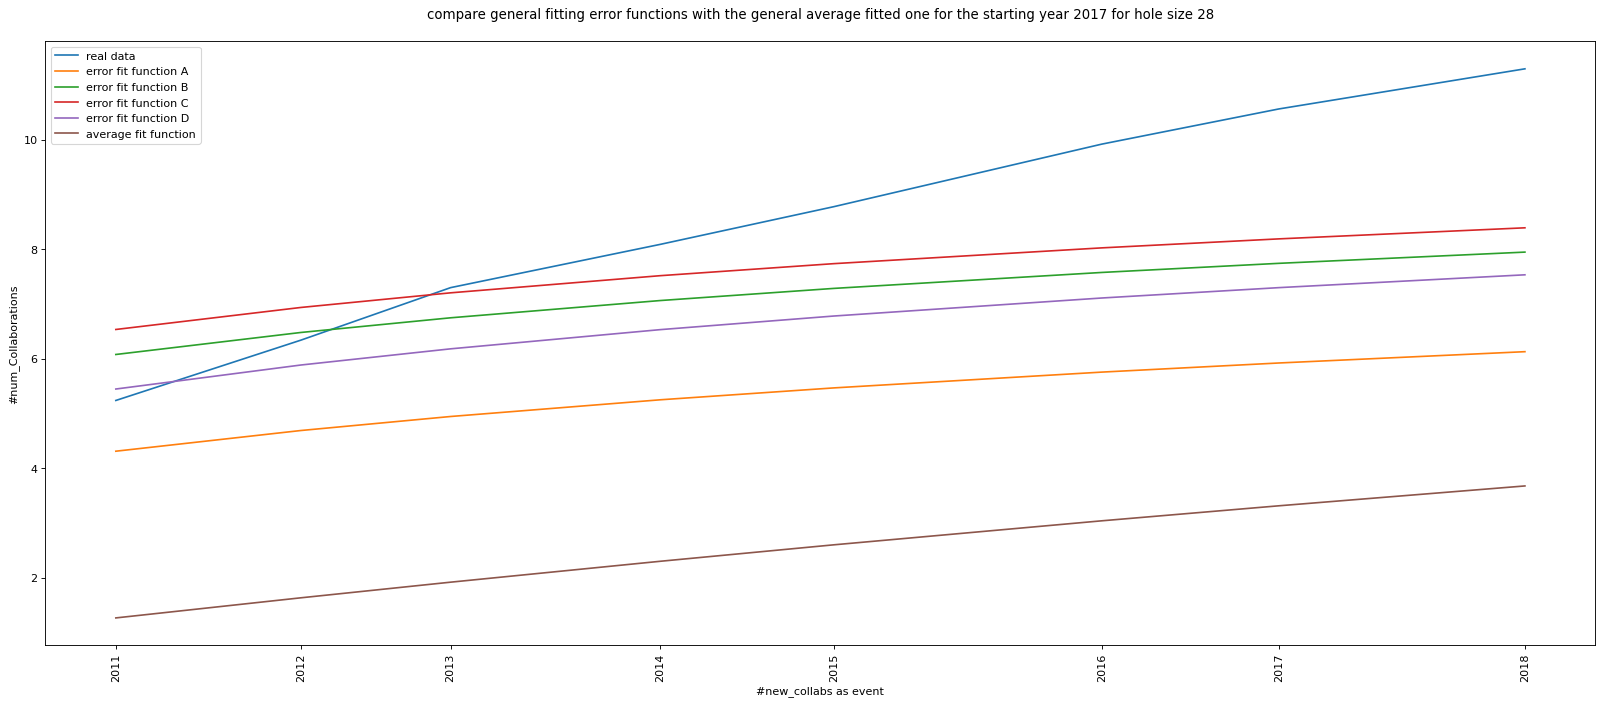

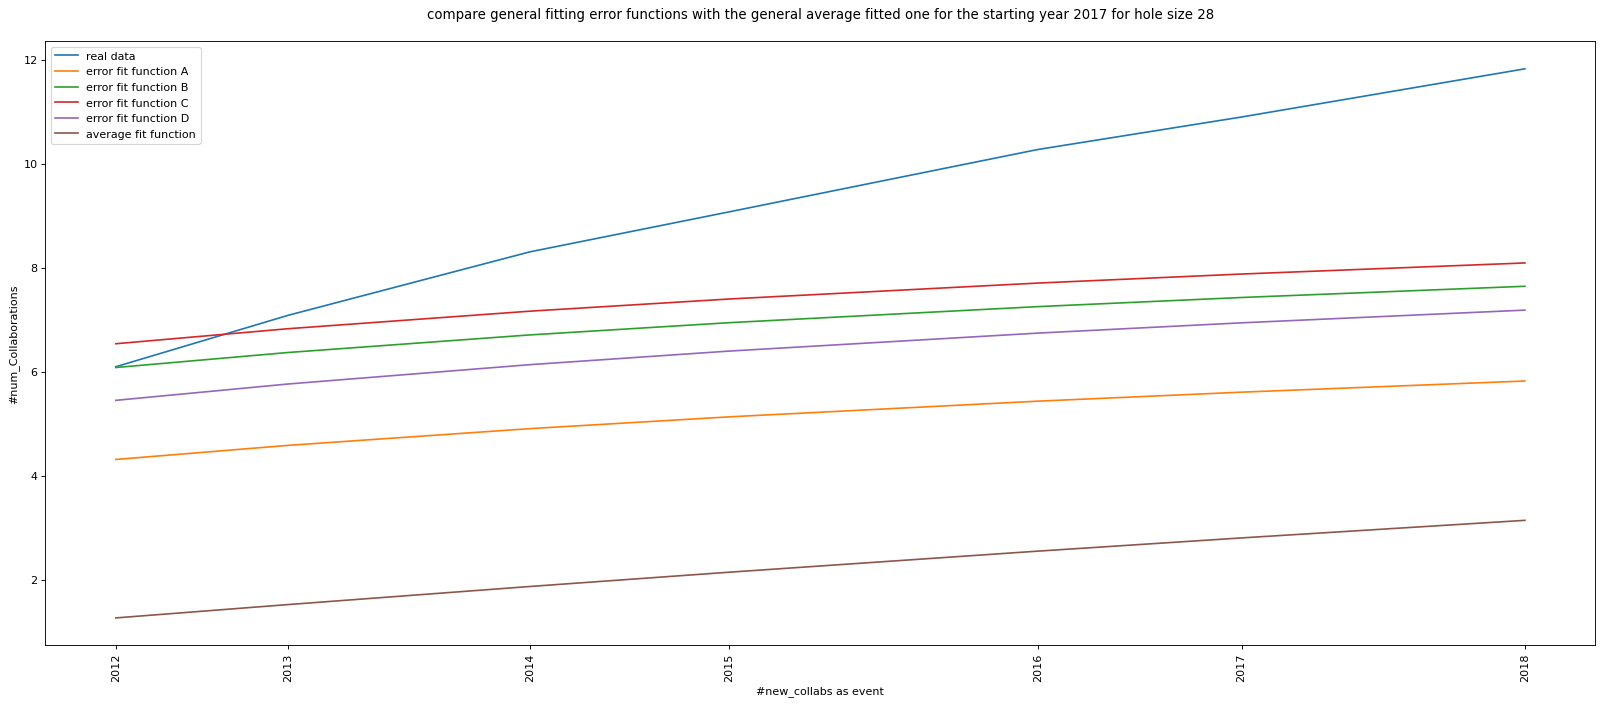

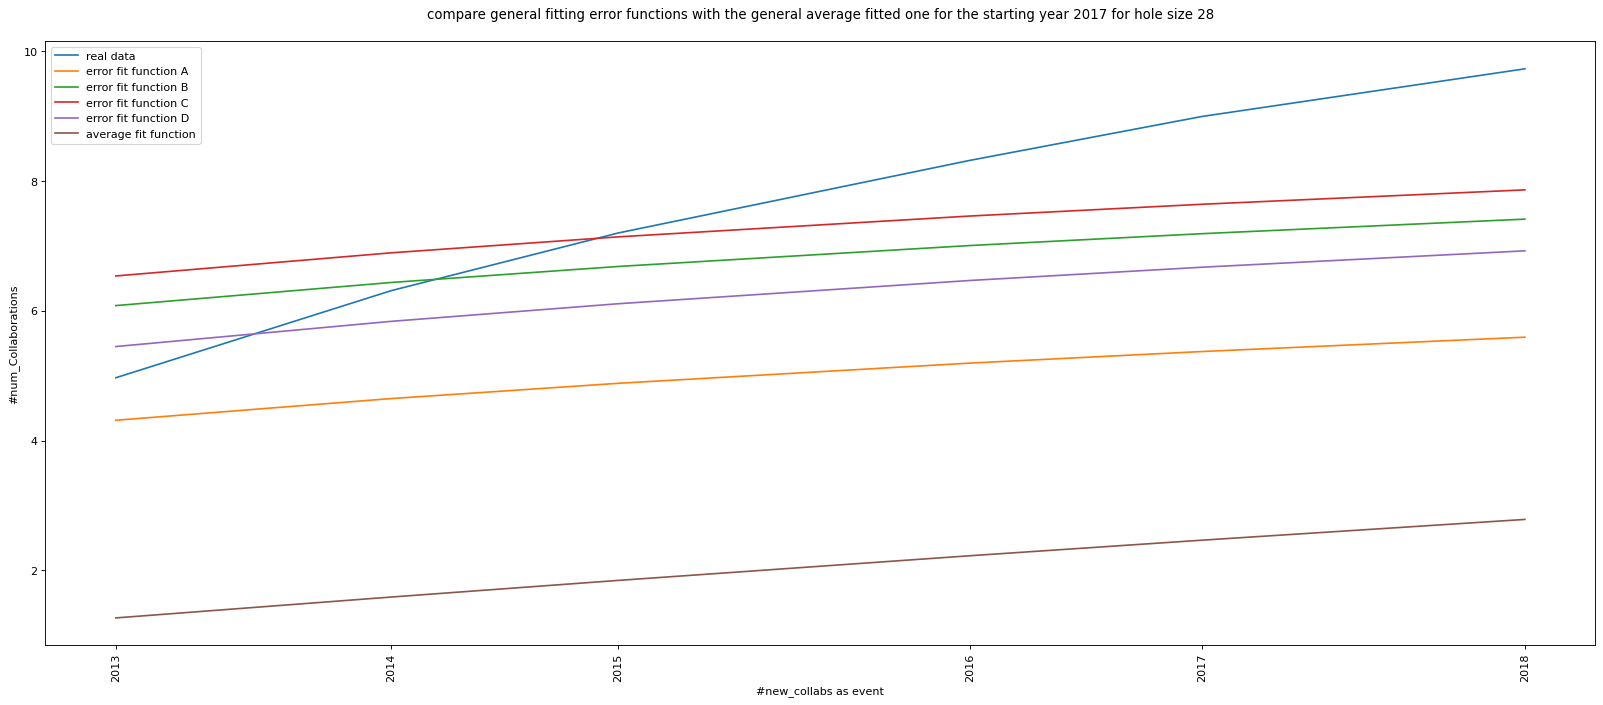

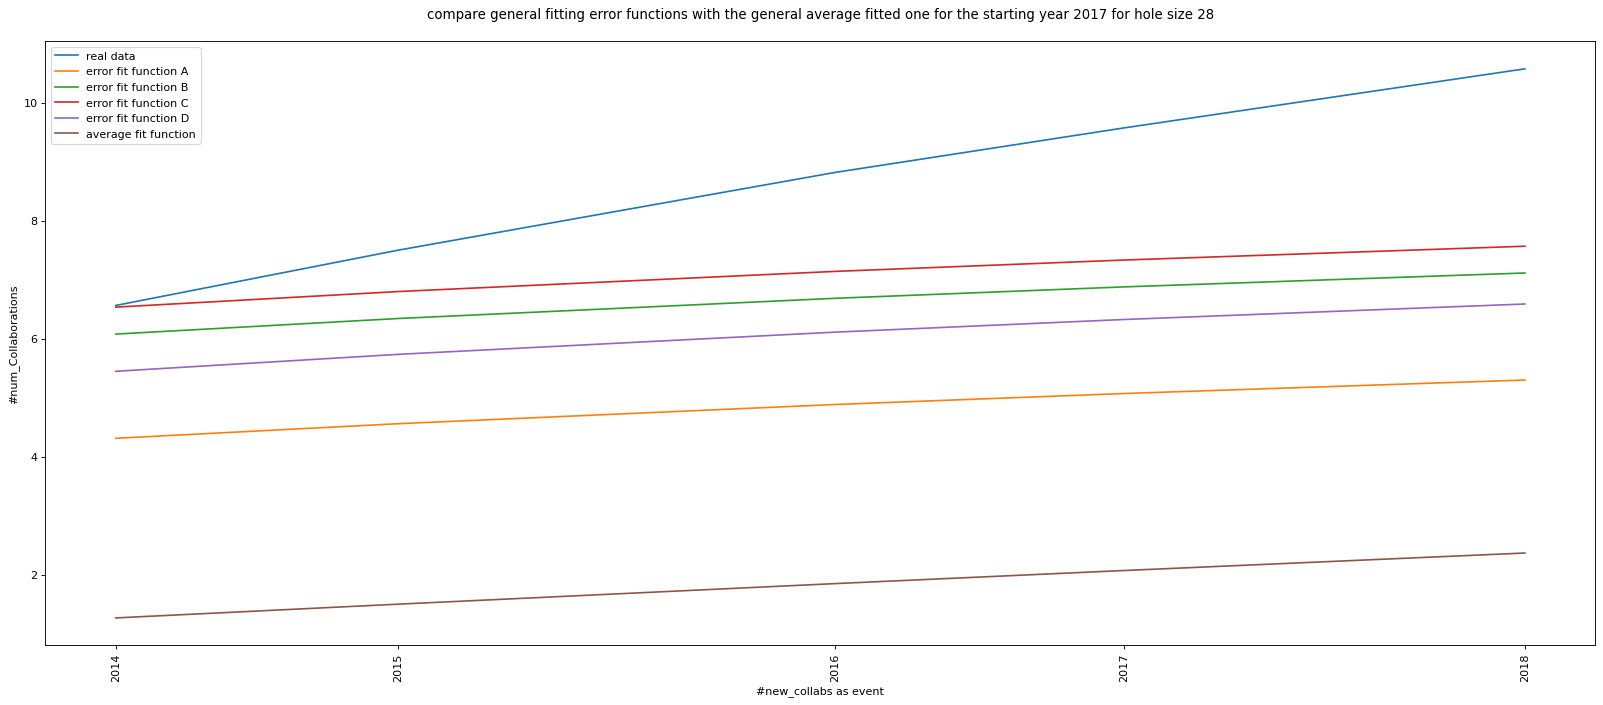

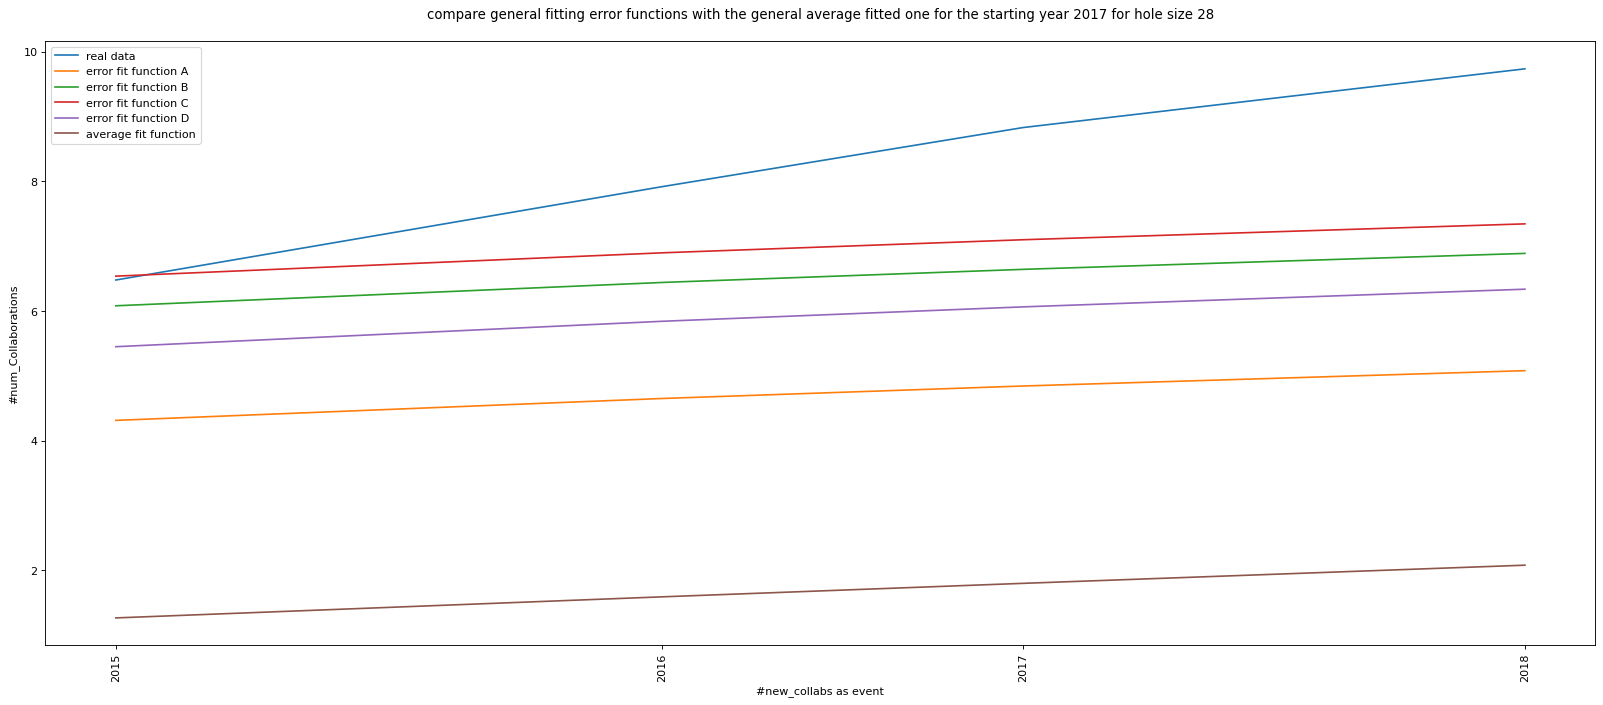

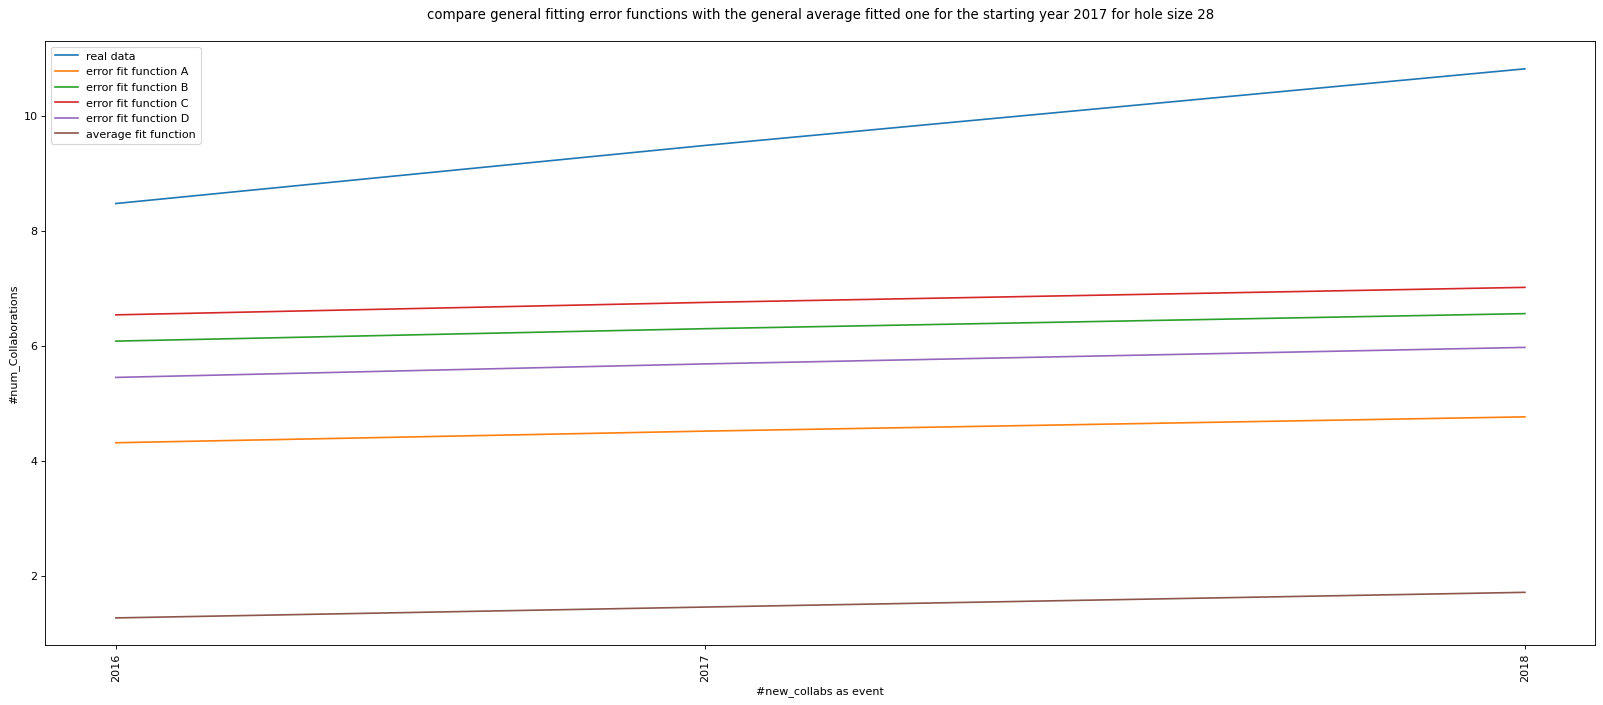

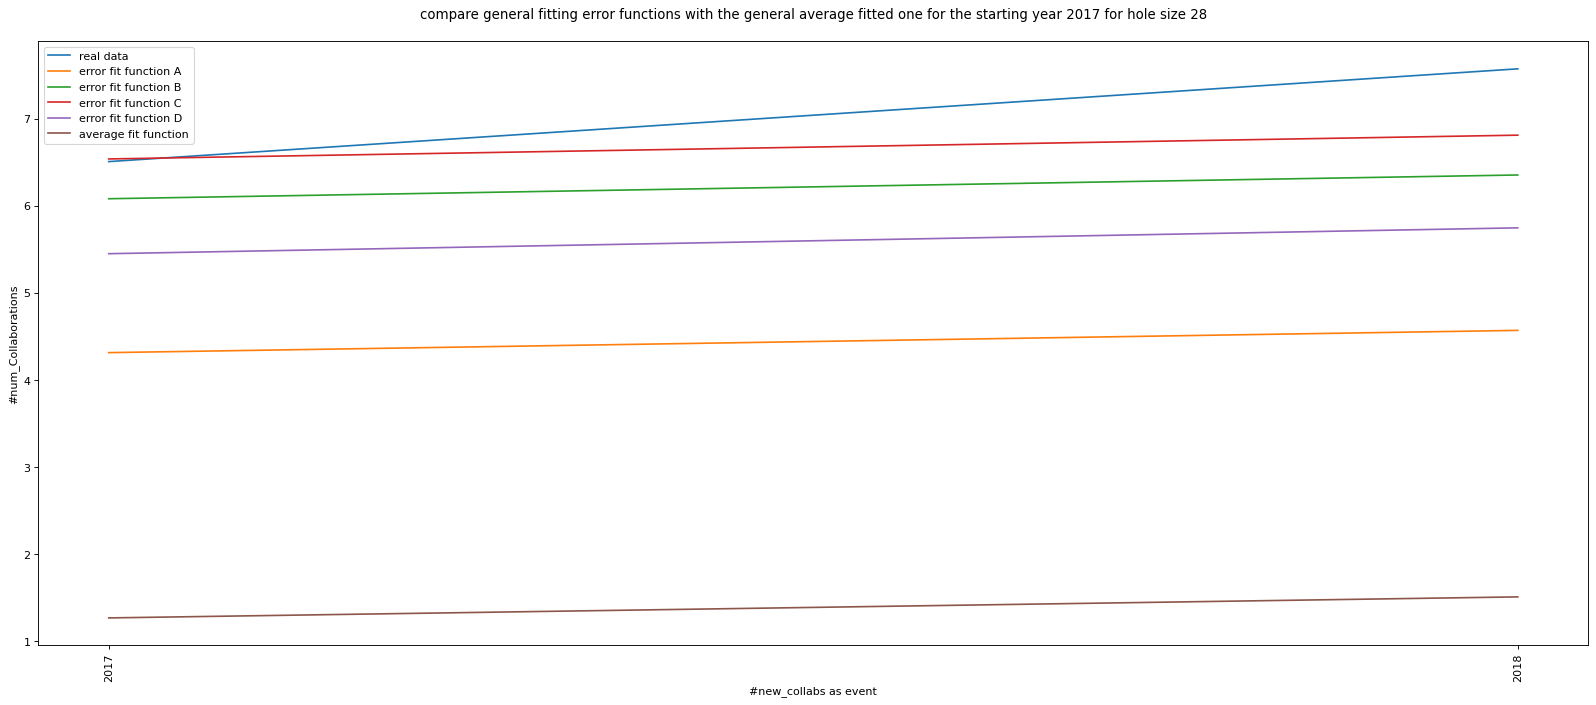

In [324]:
# given the start_y to consider it plots the real curver, the error fitted one and the average fitted toghether 
for start_y in YEARS[:-1]:
    plt.figure(figsize=(25, 10), dpi=80)
    plt.title("compare general fitting error functions with the general average fitted one for the starting year " + start_y_to_use + " for hole size "+ str(HOLE_SIZE) +  "\n", fontdict = {'fontsize' : 12})
    plt.xlabel("#new_collabs as event")
    plt.ylabel("#num_Collaborations")
    plt.xticks(rotation='vertical')

    j = YEARS.index(start_y)
    x,y = get_avg_trajectories(events, HOLE_SIZE, start_y)

    plt.plot(x,y, label="real data")
    
    for i in range(len(error_f_labels)):
        plt.plot(x, error_fit_functions[error_f_labels[i]][j], label="error fit function "+ error_f_labels[i])
    
    plt.plot(x, average_fit_functions[j], label="average fit function")

    plt.xticks(rotation='vertical')    
    plt.legend(loc='upper left')
    plt.xticks(x, YEARS[j:])
    plt.show()